# Engenius '20 - Sales Prediction

## Overview

The Main goal is to predict the quantities sold of a set of products within a 4 months time frame.

# Table of Contents

- Exploratory Data Analysis
    -  Missing & Erroneous Value Treatment
    -  Distribution of Products Sold
    - Product Insights
- Product And Sector Investigation
- Missing & Erroneous Value Treatment
- Acquisition of Socio-Economical And Demographical Data
    - Gross Domestic Product By City
    - Life Expectancy By City
    - Population By City
    - Population Growth Rate And Population Density By City
    - Retail Purchases Monthly Change With WAT Without Seasonal Influences
- Feature Creation
- Resources

# Exploratory Data Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import math

#https://github.com/nalepae/pandarallel
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=6)


product_sheets = ['PRODUCT_A', 'PRODUCT_B', 'PRODUCT_C', 'PRODUCT_V', 'PRODUCT_X']
products = product_sheets
data = {}

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:

for s in product_sheets:
    data[s] = pd.read_excel('datasets/Data2017-2019.xls', s)
    

In [3]:
# merge data frames for all 5 products vertically
df_all5 = data[product_sheets[0]]
for i,s in enumerate(product_sheets):
    if i != 0:
        df_all5 = df_all5.append(data[s], ignore_index=True)


In [4]:
df_all5.shape

(58032, 5)

In [5]:
df_all5.Product.value_counts()

PRODUCT_C    17980
PRODUCT_B    17962
PRODUCT_A    17371
PRODUCT_X     2920
PRODUCT_V     1799
Name: Product, dtype: int64

### Missing & Erroneous Value Treatment
- ratio of null values
  No null values as seen below

In [6]:
(df_all5.isnull().sum() / df_all5.shape[0])

Year        0.0
Period      0.0
Product     0.0
Province    0.0
Quantity    0.0
dtype: float64

In [7]:
def internationalize_the_text(text):
    result = text.upper().replace('Ü','U').replace('Ğ','G').replace('İ','I').replace('Ş','S').replace('Ç','C').replace('Ö','O').replace('AFYONKARAHISAR', 'AFYON').replace('MERSIN', 'ICEL')
    return result

#### ratio of transactions (sales) with negative quantities
 - probably product return

In [8]:
(df_all5[df_all5.Quantity < 0].shape[0] / df_all5.shape[0])

0.0016197959746346844

In [9]:
data_sorted = df_all5.sort_values(by=['Period', 'Province', 'Product']).reset_index(drop=True)
data_sorted.head(5)

Year  Period    Product Province  Quantity
0  2017  201701  PRODUCT_A    ADANA        11
1  2017  201701  PRODUCT_A    ADANA        25
2  2017  201701  PRODUCT_A    ADANA        54
3  2017  201701  PRODUCT_A    ADANA        17
4  2017  201701  PRODUCT_A    ADANA        30

In [10]:
print('there is a typo in province names')
len(data_sorted.Province.unique())

there is a typo in province names


82

In [11]:
data_sorted = df_all5.sort_values(by=['Period', 'Province', 'Product']).reset_index(drop=True)
data_sorted.head(5)

Year  Period    Product Province  Quantity
0  2017  201701  PRODUCT_A    ADANA        11
1  2017  201701  PRODUCT_A    ADANA        25
2  2017  201701  PRODUCT_A    ADANA        54
3  2017  201701  PRODUCT_A    ADANA        17
4  2017  201701  PRODUCT_A    ADANA        30

In [12]:
# fixes ıstanbul typo
data_sorted['Province'] = data_sorted.Province.apply(lambda x: 'ISTANBUL' if x == 'İSTANBUL' else x)
data_sorted['Province'] = data_sorted.Province.apply(lambda x: 'CANAKKALE' if x == 'ÇANAKKKALE' else x)

In [13]:
#aggragate products sold
data_aggregated = data_sorted.groupby(['Period', 'Province', 'Product'])['Quantity'].sum().reset_index()
data_aggregated.head(8)

Period  Province    Product  Quantity
0  201701     ADANA  PRODUCT_A       346
1  201701     ADANA  PRODUCT_B      4838
2  201701     ADANA  PRODUCT_C      1004
3  201701     ADANA  PRODUCT_V        20
4  201701     ADANA  PRODUCT_X       910
5  201701  ADIYAMAN  PRODUCT_A        36
6  201701  ADIYAMAN  PRODUCT_B        45
7  201701  ADIYAMAN  PRODUCT_C       206

In [14]:
data_aggregated.shape

(13343, 4)

### Filling mising sample rows due to no sale

In [15]:
data_aggregated.head()

Period Province    Product  Quantity
0  201701    ADANA  PRODUCT_A       346
1  201701    ADANA  PRODUCT_B      4838
2  201701    ADANA  PRODUCT_C      1004
3  201701    ADANA  PRODUCT_V        20
4  201701    ADANA  PRODUCT_X       910

In [16]:
cr_indices = data_aggregated.set_index(['Period', 'Province', 'Product']).index.tolist()
all_possible_combinations = []
# let's populate all possible index value combinations (vertical)
for period in data_aggregated.Period.value_counts().index.tolist():
    for province in data_aggregated.Province.value_counts().index.tolist():
        for product in data_aggregated.Product.value_counts().index.tolist():
            all_possible_combinations.append((period, province, product))

# detecting missing ones
missing_index_combinations = all_possible_combinations
for e in cr_indices:
    missing_index_combinations.remove(e)
len(missing_index_combinations)

#populating the missing entries
data_missing = pd.DataFrame(columns=['Period', 'Province', 'Product', 'Quantity'])
for i,m in enumerate(missing_index_combinations):
    if i == 0:
        print(m)
    data_missing.loc[i] = list(m) + [0]
    
print(data_missing.head())
print(data_missing.shape)
data_aggregated = data_aggregated.append(data_missing).sort_values(by=['Period', 'Province', 'Product'], ascending=True).reset_index(drop=True)
data_aggregated.tail()

(201910, 'MALATYA', 'PRODUCT_V')
   Period  Province    Product Quantity
0  201910   MALATYA  PRODUCT_V        0
1  201910    BURDUR  PRODUCT_V        0
2  201910     SİVAS  PRODUCT_V        0
3  201910    MARDIN  PRODUCT_V        0
4  201910  ADIYAMAN  PRODUCT_V        0
(1237, 4)


Period Province    Product Quantity
14575  201912   ŞIRNAK  PRODUCT_A       28
14576  201912   ŞIRNAK  PRODUCT_B      144
14577  201912   ŞIRNAK  PRODUCT_C      323
14578  201912   ŞIRNAK  PRODUCT_V        0
14579  201912   ŞIRNAK  PRODUCT_X       27

#### The most common cities which did not received any specific product in a month
 - The small towns surely have a weak impulse in demand and low inventory turnover rate.

In [17]:
data_missing.Province.value_counts()[:8]

ARDAHAN     51
HAKKARİ     51
TUNCELİ     46
BAYBURT     42
SİİRT       41
IĞDIR       36
KİLİS       36
ERZİNCAN    35
Name: Province, dtype: int64

#### The most common products which did not delivered to any specific city in a month
- Product V -the vitamin- appears to be the most dispensable product of all 5.
- Or it might be due to tug of wars, competetive weaknes and/or minor market share in terms of that very product category.

In [18]:
data_missing.Product.value_counts()

PRODUCT_V    1153
PRODUCT_A      48
PRODUCT_X      32
PRODUCT_B       4
Name: Product, dtype: int64

In [19]:
new_periods = ["{}{}".format(a,b) for a, b in zip(4*['2020'], ['01', '02', '03', '04'])]
cols = data_aggregated.columns
new_data = []
for c in data_aggregated.Province.unique().tolist():
    for tp in new_periods:
        for p in product_sheets:
            cr_data = [tp, c, p, 0 ]
            #print(type(cr_data))
            new_data.append(cr_data)

data_enlargement = pd.DataFrame(columns=cols, data=new_data)
data_enlargement.head()

Period Province    Product  Quantity
0  202001    ADANA  PRODUCT_A         0
1  202001    ADANA  PRODUCT_B         0
2  202001    ADANA  PRODUCT_C         0
3  202001    ADANA  PRODUCT_V         0
4  202001    ADANA  PRODUCT_X         0

In [20]:
data_aggregated.head()

Period Province    Product Quantity
0  201701    ADANA  PRODUCT_A      346
1  201701    ADANA  PRODUCT_B     4838
2  201701    ADANA  PRODUCT_C     1004
3  201701    ADANA  PRODUCT_V       20
4  201701    ADANA  PRODUCT_X      910

In [21]:
data_aggregated_enlarged = data_aggregated.append(data_enlargement)
data_aggregated_enlarged.Quantity = data_aggregated_enlarged.Quantity.astype(int)
data_aggregated_enlarged.tail()

Period Province    Product  Quantity
1615  202004   ŞIRNAK  PRODUCT_A         0
1616  202004   ŞIRNAK  PRODUCT_B         0
1617  202004   ŞIRNAK  PRODUCT_C         0
1618  202004   ŞIRNAK  PRODUCT_V         0
1619  202004   ŞIRNAK  PRODUCT_X         0

In [22]:
#split the composite period feature also into its year and month components
data_aggregated['Month'] = data_aggregated['Period'].apply(lambda x: int(str(x)[4:]))
data_aggregated['Year'] = data_aggregated['Period'].apply(lambda x: int(str(x)[:4]))

data_aggregated_enlarged['Month'] = data_aggregated_enlarged['Period'].apply(lambda x: int(str(x)[4:]))
data_aggregated_enlarged['Year'] = data_aggregated_enlarged['Period'].apply(lambda x: int(str(x)[:4]))

In [23]:
data_aggregated_enlarged.head()

Period Province    Product  Quantity  Month  Year
0  201701    ADANA  PRODUCT_A       346      1  2017
1  201701    ADANA  PRODUCT_B      4838      1  2017
2  201701    ADANA  PRODUCT_C      1004      1  2017
3  201701    ADANA  PRODUCT_V        20      1  2017
4  201701    ADANA  PRODUCT_X       910      1  2017

In [24]:
data_aggregated.to_csv('datasets/data_aggregated.csv', index=False)

#### Checkpoint-1

In [25]:
data_aggregated = pd.read_csv('datasets/data_aggregated.csv')

In [26]:
data_aggregated.head()

Period Province    Product  Quantity  Month  Year
0  201701    ADANA  PRODUCT_A       346      1  2017
1  201701    ADANA  PRODUCT_B      4838      1  2017
2  201701    ADANA  PRODUCT_C      1004      1  2017
3  201701    ADANA  PRODUCT_V        20      1  2017
4  201701    ADANA  PRODUCT_X       910      1  2017

In [27]:
# standardizes all province names for further usage and make easy to integrate more datasets
data_aggregated.Province = data_aggregated.Province.apply(lambda x: internationalize_the_text(x))

In [28]:
data_aggregated.shape

(14580, 6)

### Distribution of Products Sold

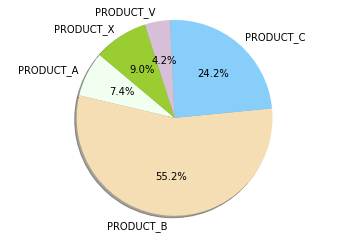

Product
PRODUCT_A     576747
PRODUCT_B    4291439
PRODUCT_C    1879572
PRODUCT_V     324499
PRODUCT_X     696845
Name: Quantity, dtype: int64

In [29]:
labels = product_sheets
sizes = data_aggregated.groupby(['Product'])['Quantity'].sum().sort_index().tolist()
colors = ['honeydew', 'wheat', 'lightskyblue', 'thistle', 'yellowgreen']
#explode = (0.1, 0)  # explode 1st slice

plt.pie(sizes, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

data_aggregated.groupby(['Product'])['Quantity'].sum().sort_index()

### Geographical Distribution of Sales By City

In [30]:
#cities world-countries.json > the coordinates file is cited (please look at Resources #1)
turkey_cities_json_source = 'geo_json/tr-cities-utf8.json'

In [31]:
data_heat_general = data_aggregated[['Province', 'Quantity']]
data_heat_general = data_heat_general.groupby(['Province'])['Quantity'].sum().reset_index()
data_heat_general['Province'] = data_heat_general['Province'].apply(lambda x: x.capitalize().replace('i̇', 'i')) 
data_heat_general.head()

data_heat_general.sort_values(by=['Province'], ascending=True).reset_index(drop=True)[:5]

Province  Quantity
0     Adana    202564
1  Adiyaman     21711
2     Afyon     60131
3      Agri     47827
4   Aksaray     46315

In [32]:
# matching and correcting city names
city_correction_dict = {}
city_correction_dict['Adiyaman'] = 'Adıyaman'
city_correction_dict['Agri'] = 'Ağrı'
city_correction_dict['Aydin'] = 'Aydın'
city_correction_dict['Balikesir'] = 'Balıkesir'
city_correction_dict['Bartin'] = 'Bartın'
city_correction_dict['Bingol'] = 'Bingöl'
city_correction_dict['Corum'] = 'Çorum'
city_correction_dict['Canakkkale'] = 'Çanakkale'
city_correction_dict['Cankiri'] = 'Çankırı'
city_correction_dict['Diyarbakir'] = 'Diyarbakır'
city_correction_dict['Duzce'] = 'Düzce'
city_correction_dict['Elazig'] = 'Elazığ'
city_correction_dict['Eskisehir'] = 'Eskişehir'
city_correction_dict['Gumushane'] = 'Gümüşhane'
city_correction_dict['Igdir'] = 'Iğdır'
city_correction_dict['Istanbul'] = 'İstanbul'
city_correction_dict['Izmir'] = 'İzmir'
city_correction_dict['Karabuk'] = 'Karabük'
city_correction_dict['Kahramanmaras'] = 'Kahramanmaraş'
city_correction_dict['Kirikkale'] = 'Kırıkkale'
city_correction_dict['Kirklareli'] = 'Kırklareli'
city_correction_dict['Kirsehir'] = 'Kırşehir'
city_correction_dict['Kutahya'] = 'Kütahya'
city_correction_dict['Icel'] = 'Mersin'
city_correction_dict['Mugla'] = 'Muğla'
city_correction_dict['Nevsehir'] = 'Nevşehir'
city_correction_dict['Nigde'] = 'Niğde'
city_correction_dict['Sanliurfa'] = 'Şanlıurfa'
city_correction_dict['Sirnak'] = 'Şırnak'
city_correction_dict['Mus'] = 'Muş'
city_correction_dict['Tekirdag'] = 'Tekirdağ'
city_correction_dict['Usak'] = 'Uşak'


data_heat_general['Province'] = data_heat_general['Province'].apply(lambda x: city_correction_dict[x] if x in city_correction_dict.keys() else x) 

In [33]:
data_heat_general['Quantity'] = data_heat_general['Quantity'].apply(lambda x: math.log(x+0.001))
data_heat_general.head(10)

Province   Quantity
0     Adana  12.218811
1  Adıyaman   9.985574
2     Afyon  11.004281
3      Ağrı  10.775346
4   Aksaray  10.743221
5    Amasya  10.457574
6    Ankara  13.036670
7   Antalya  12.732808
8   Ardahan   7.971431
9    Artvin   9.007367

In [34]:
# An open source geographical heat map library used for data visualization (please look at Resources #2)
import folium

turkey_heat_map_general_products_sold_by_city = folium.Map(
    location=[39.855555, 34.665873],
    #tiles='Stamen Terrain',
    zoom_start=5
)

turkey_heat_map_general_products_sold_by_city.choropleth(geo_data=turkey_cities_json_source, data=data_heat_general, columns=['Province', 'Quantity'], key_on='feature.properties.name',
                         fill_color='OrRd', fill_opacity=0.7,  line_opacity=0.2, nan_fill_color='black', nan_fill_opacity=0.2)

turkey_heat_map_general_products_sold_by_city

/home/a/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## Product Insights

In [35]:
# plots the historical sales data for the wanted product
import seaborn as sns
def plot_historical_sales_data_for_the_product_wanted(product_name):
    data_sales_product = data_aggregated[data_aggregated['Product'] == product_name].groupby(['Period'])['Quantity'].sum().reset_index()
    data_sales_product['Period'] = data_sales_product['Period'].astype(str)
    fig,ax = plt.subplots(figsize=(12,4))
    ax.set_xticklabels(range(0,36))
    sns.lineplot(x="Period", y="Quantity", ax=ax, data=data_sales_product)
    plt.xticks(rotation=15)
    plt.title(product_name + ' Sales')
    plt.show()
    data_sales_product.set_index('Period').transpose()

In [36]:
#scatter plot Province/Quantity
def plot_scattered_mean_sales_by_city(product_name):
    data_province_quantity = data_aggregated[data_aggregated['Product'] == product_name].groupby(['Province'])['Quantity'].mean().reset_index()
    max_avg = data_province_quantity.Quantity.max()
    print("max_avg: {}".format(max_avg))
    print(data_province_quantity.sort_values(by=['Quantity'], ascending=False).head())
    
    var = 'Province'
    series_var = data_province_quantity[var].copy()
    for i in range(0, len(series_var)):
        series_var[i] = i+1
    
    data = pd.concat([data_province_quantity['Quantity'], series_var], axis=1)
    data.plot.scatter(x=var, y='Quantity', ylim=(0,max_avg*1.1));
    return data_province_quantity

In [37]:
def display_pie_chart(data_province_quantity):
    labels = data_province_quantity['Province'].tolist()
    sizes = data_province_quantity['Quantity'].tolist()
    labels = minor_label_filter(labels, sizes, 0.03)
    colors = ['honeydew', 'wheat', 'lightskyblue', 'thistle', 'yellowgreen']
    explode = (0.1, 0)  # explode 1st slice

    plt.pie(sizes, labels=labels, colors=colors, autopct=func_autopct, shadow=True, startangle=150)

    plt.axis('equal')
    plt.show()
    
def func_autopct(pct):
    return ('%.2f' % pct) if pct > 3 else ''
def minor_label_filter(labels, sizes, threshold_percent):
    for i,x in enumerate(sizes):
        if x/sum(sizes) < threshold_percent:
            labels[i] = ''
    return labels

## Product A

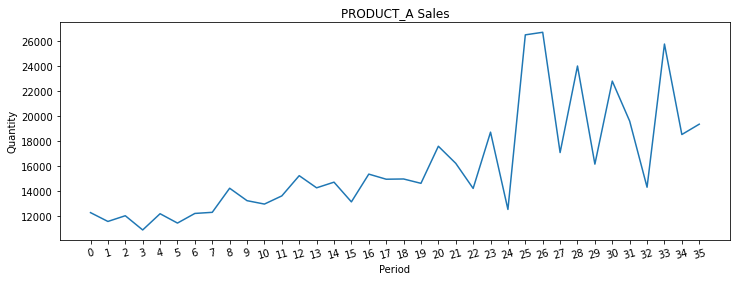

In [38]:
plot_historical_sales_data_for_the_product_wanted('PRODUCT_A')

max_avg: 3987.6666666666665
    Province     Quantity
40  ISTANBUL  3987.666667
6     ANKARA  1698.250000
41     IZMIR  1083.416667
7    ANTALYA   827.305556
0      ADANA   483.055556


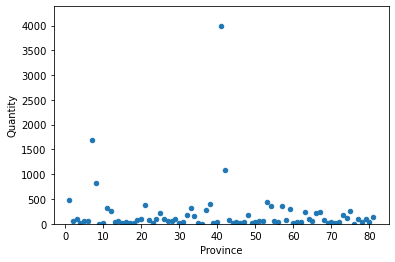

In [39]:
data_last_product = plot_scattered_mean_sales_by_city('PRODUCT_A')

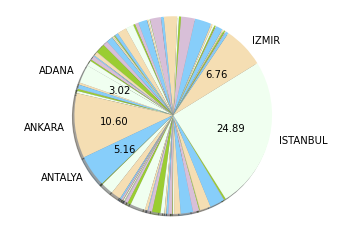

In [40]:
display_pie_chart(data_last_product)

## Product B

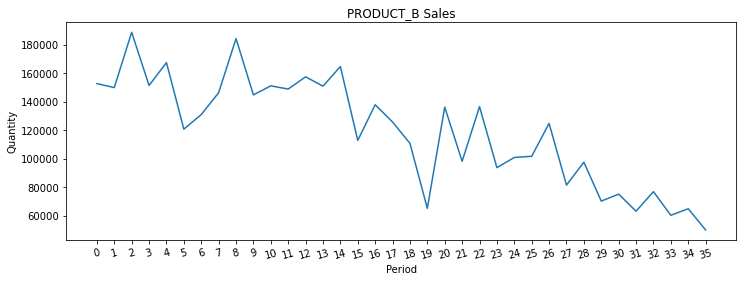

In [41]:
plot_historical_sales_data_for_the_product_wanted('PRODUCT_B')

## Product C

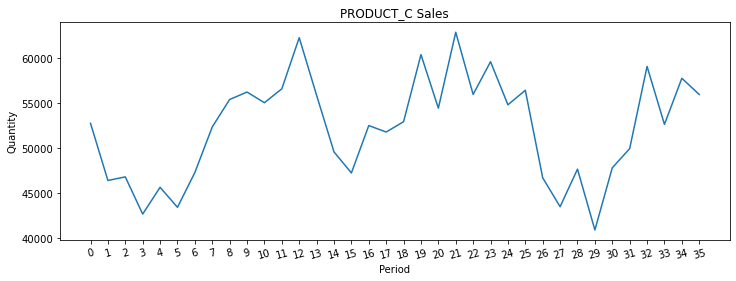

In [42]:
plot_historical_sales_data_for_the_product_wanted('PRODUCT_C')

## Product X

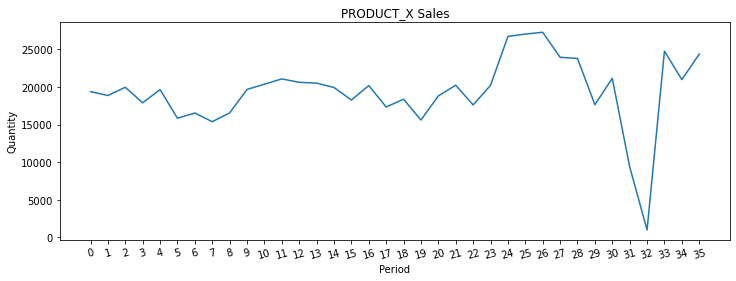

In [43]:
plot_historical_sales_data_for_the_product_wanted('PRODUCT_X')

## Product V

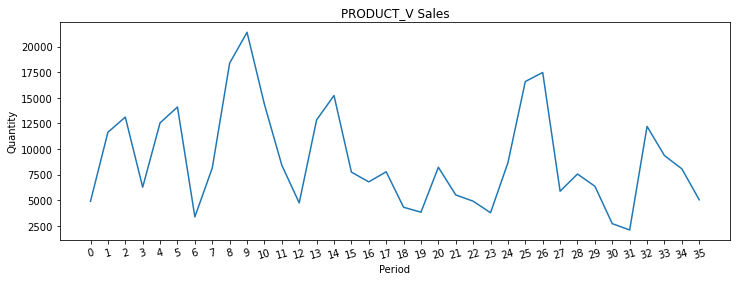

In [44]:
plot_historical_sales_data_for_the_product_wanted('PRODUCT_V')

# Product And Sector Investigation

# Acquisition of Socio-Economical And Demographical Data

### Gross Domestic Product By City
This demonstrates the accumulated wealth and flourishing of the city

In [45]:
# (please look at Resources #7)
data_gdp_by_city = pd.read_csv('datasets/tuik/gdp_by_city_2018.csv', delimiter='|')

In [46]:
data_gdp_by_city = data_gdp_by_city.transpose().reset_index().rename(columns={0: 'GDP by City', 'index': 'Province'})
data_gdp_by_city['city_id'] = pd.to_numeric(data_gdp_by_city['Province'].apply(lambda x: x.split('-')[1]))
data_gdp_by_city['city_id'] = data_gdp_by_city['city_id'].apply(lambda x: x-1)
data_gdp_by_city['Province'] = data_gdp_by_city['Province'].apply(lambda x: x.split('-')[0])
data_gdp_by_city = data_gdp_by_city.set_index('city_id').sort_index()

In [47]:
data_gdp_by_city.head(3)

Province  GDP by City
city_id                             
0                 Adana   72187342.0
1              Adıyaman   13958454.0
2        Afyonkarahisar   22804455.0

### Life Expectancy By City
This may indicate how much does an ordinary citizen cares of his/her health in that particular city

In [48]:
# (please look at Resources #8)
data_life_expectancy_by_city = pd.read_csv('datasets/tuik/life_expectancy_by_city.csv')
data_life_expectancy_by_city.tail(3)

Province  life_expectancy
78     Kilis             76.1
79  Osmaniye             78.0
80     Düzce             77.5

### Population By City
This feature undisputedly should have a positive correlation with the number of products sold in that city.

In [49]:
# (please look at Resources #9)
data_population_by_city = pd.read_csv('datasets/tuik/population_by_city_2018.csv')
data_population_by_city['population'] = pd.to_numeric(data_population_by_city['population'].apply(lambda x: x.replace(" ", "")))
data_population_by_city.head(3)

Province  population
0           Adana     2220125
1        Adıyaman      624513
2  Afyonkarahisar      725568

### Population Growth Rate And Population Density By City
Since it reveals the number of newborns and toddlers, Population Growth Rate most probably contributes to the performance of our models especially for PRODUCT_C to a certain extend.

In [50]:
# ((please look at Resources #10)
data_population_growth_rate_density_by_city = pd.read_csv('datasets/tuik/pop_density_and_growth_rate.csv')
#data_population_by_city['population'] = pd.to_numeric(data_population_by_city['population'].apply(lambda x: x.replace(" ", "")))
data_population_growth_rate_density_by_city.head(3)

Province  pop_growth_rate_2016_2017  pop_growth_rate_2017_2018  \
0           Adana                        6.7                        1.6   
1        Adıyaman                        7.5                       15.2   
2  Afyonkarahisar                        1.6                       13.7   

   pop_growth_rate_2018_2019 pop_density_2017 pop_density_2018  \
0                        8.0              159              160   
1                        3.1               87               89   
2                        5.4               50               51   

  pop_density_2019  
0              161  
1               89  
2               51

### Retail Purchases Monthly Change With WAT Without Seasonal Influences (Base Prices - 2015)

- This data may demonstrate consumer behaviour in some sense.

- The monthly increase of 13.2% is remarkable for March, 2020 in which the first covid-19 case is announced in Turkey.

- We did not included online purchase data, since online drug purchases are strictly forbidden by local (Turkish) laws and regulations. In accordance with the law no. 6197, pharmacies are not even allowed to publish websites.

(please look at Resources #20 and #21)


In [51]:
# (please look at Resources #19)
data_monthly_retail_purchases_change = pd.read_csv('datasets/tuik/retail_purchases_monthly_with_wat_without_seasonal_influences_base_2015_prices.csv', delimiter='|')
data_monthly_retail_purchases_change = data_monthly_retail_purchases_change.set_index(['year']).transpose().reset_index(drop=True)
data_monthly_retail_purchases_change

year  2017  2018  2019  2020
0      0.1   2.2  -0.3   0.3
1      0.2  -1.3  -0.4   3.6
2     -0.1   0.7   2.5  13.2
3      1.5   0.7  -0.2  -4.2
4      1.4   0.8   1.4   NaN
5     -1.0  -1.7  -0.3   NaN
6      0.1   0.0   0.0   NaN
7      4.9   0.9   1.5   NaN
8     -4.4  -2.8   1.1   NaN
9      4.0  -3.3   0.2   NaN
10     1.2   0.3   0.9   NaN
11     2.6   0.3  -1.0   NaN

### EUR/TRY, USD/TRY Exchange Rates, EUR/USD Parity and Monthly Turkish Minimum Wage in USD

In [52]:
data_forex = pd.read_csv('datasets/manual/USDTRYEUR.csv')
data_forex.tail()

Period  USD/TRY_Price USD/TRY_Change %  EUR/TRY_Price EUR/TRY_Change %  \
35  201912         5.9489            3.51%         6.6699            5.34%   
36  202001         5.9822            0.56%         6.6367           -0.50%   
37  202002         6.2427            4.35%         6.8835            3.72%   
38  202003         6.6143            5.95%         7.2962            6.00%   
39  202004         6.9864            5.63%         7.6550            4.92%   

    EUR/USD_Price EUR/USD_Change %      mw_USD  
35         1.1212            1.77%  339.558574  
36         1.1094           -1.05%  388.602855  
37         1.1027           -0.61%  372.386948  
38         1.1031            0.04%  351.465764  
39         1.0957           -0.67%  332.746479

### Open Days for Pharmacies

We manually gathered the number of open days for each month. We counted saturdays as 0.5 since some of the pharmacies are open on these days and some does not.

In [53]:
data_open_days_for_pharmacies = pd.read_csv('datasets/manual/no_of_workdays_monthly.csv')
data_open_days_for_pharmacies.tail()

Period  open_days_for_pharmacies
35  201912                      24.0
36  202001                      24.0
37  202002                      22.5
38  202003                      24.0
39  202004                      23.0

# Feature Creation

## Acquiring Infant and Toddlers Distrubution By City (0-4) by processing children count by age and city

- This age bracket strongly correlates peculiarly with Product C as stressed in EnGenius '20 presentation document.   (please look at Resources #11)

In [54]:
# (please look at Resources #12)
data_children_count_by_age_and_city = pd.read_csv('datasets/tuik/children_number_by_age_and_city.csv', delimiter='|')
data_children_count_by_age_and_city = data_children_count_by_age_and_city.drop(columns=['Satırlar', 'Unnamed: 84'])
data_children_count_by_age_and_city = data_children_count_by_age_and_city.rename(columns={"Unnamed: 1": "category", "Unnamed: 2": "year"})
data_children_count_by_age_and_city['category'] = data_children_count_by_age_and_city['category'].fillna(method='ffill')
data_children_count_by_age_and_city['age'] = pd.to_numeric(data_children_count_by_age_and_city['category'].apply(lambda x: x.split(':')[2]))
data_children_count_by_age_and_city['gender'] = data_children_count_by_age_and_city['category'].apply(lambda x: (x.split(' ')[0]).split(':')[1])
data_children_count_by_age_and_city.head(10)

data_infants_and_toddlers = data_children_count_by_age_and_city[data_children_count_by_age_and_city.age < 5].drop(columns=['category', 'gender', 'age']).groupby(['year']).sum().reset_index()
data_infants_and_toddlers = data_infants_and_toddlers.rename(columns={'year': 'Province'}).set_index(['Province']).transpose()
data_infants_and_toddlers = data_infants_and_toddlers.reset_index()
data_infants_and_toddlers['Province'] = data_infants_and_toddlers['index'].apply(lambda x: x.split('-')[0])
data_infants_and_toddlers['index'] = pd.to_numeric(data_infants_and_toddlers['index'].apply(lambda x: x.split('-')[1]))
data_infants_and_toddlers = data_infants_and_toddlers.set_index('Province').sort_values(by=['index'], ascending=True)

data_infants_and_toddlers.head(3)

Province        index      2017      2018      2019
Province                                           
Adana               1  190594.0  187842.0  181508.0
Adıyaman            2   62631.0   62989.0   61142.0
Afyonkarahisar      3   52997.0   52944.0   51359.0

## Acquiring Elderly Male Population Distrubution By City And Age Groups

- These age groups for male citizens substantially correlates especially with Product X as indicated in EnGenius '20 presentation document.  (please look at Resources #11)
- As revealed with our Investigation, Product X is most probably XALFU XL product which is firstly lisanced by 'Eczacıbaşı Ilaç Pazarlama' on 01/13/2016.  (please look at Resources #16)
- The elderly males who suffer from prostate enlargement in general are on medivation with XALFU XL. (Zorlu et al., 2014) (please look at Resources #13, #14)

In [55]:
# (please look at Resources #22)
data_by_city_gender_and_age_groups = pd.read_csv('datasets/tuik/population_by_city_gender_and_age_groups.csv', delimiter='|')
data_by_city_gender_and_age_groups = data_by_city_gender_and_age_groups.rename(columns={"Unnamed: 0": "year", "Unnamed: 1": "city_id"}).drop(columns=['Unnamed: 40'])
data_by_city_gender_and_age_groups['year'] = data_by_city_gender_and_age_groups['year'].fillna(method='ffill')
data_by_city_gender_and_age_groups['Province'] = data_by_city_gender_and_age_groups['city_id'].apply(lambda x: x.split('-')[0])
data_by_city_gender_and_age_groups['city_id'] = data_by_city_gender_and_age_groups['city_id'].apply(lambda x: x.split('-')[1])
data_by_city_gender_and_age_groups = data_by_city_gender_and_age_groups.set_index('Province').sort_index()

data_by_city_gender_and_age_groups.head()

year city_id  Erkek ve 0-4  Erkek ve 10-14  Erkek ve 15-19  \
Province                                                                 
Adana     2017.0       1       97512.0         93408.0         94576.0   
Adana     2019.0       1       92880.0         96793.0         89973.0   
Adana     2018.0       1       96048.0         95457.0         91990.0   
Adıyaman  2018.0       2       32473.0         30346.0         30310.0   
Adıyaman  2019.0       2       31328.0         30335.0         29195.0   

          Erkek ve 20-24  Erkek ve 25-29  Erkek ve 30-34  Erkek ve 35-39  \
Province                                                                   
Adana            83854.0         81203.0         84918.0         89858.0   
Adana            81930.0         79820.0         81952.0         88602.0   
Adana            80062.0         79326.0         82966.0         89395.0   
Adıyaman         25557.0         23911.0         23760.0         23287.0   
Adıyaman         25753.0         24037.0         23655.0         23084.0   

          Erkek ve 40-44  ...  Kadın ve 50-54  Kadın ve 55-59  Kadın ve 5-9  \
Province                  ...                                                 
Adana            79611.0  ...         64703.0         54859.0       91647.0   
Adana            81661.0  ...         62905.0         60161.0       92347.0   
Adana            80171.0  ...         63809.0         57464.0       91203.0   
Adıyaman         19710.0  ...         13215.0         11902.0       29255.0   
Adıyaman         19849.0  ...         13312.0         12307.0       29630.0   

          Kadın ve 60-64  Kadın ve 65-69  Kadın ve 70-74  Kadın ve 75-79  \
Province                                                                   
Adana            47294.0         35249.0         23325.0         16475.0   
Adana            48575.0         38304.0         27956.0         17199.0   
Adana            47310.0         36409.0         25034.0         16748.0   
Adıyaman          9712.0          8964.0          6915.0          4598.0   
Adıyaman          9984.0          9001.0          7428.0          4832.0   

          Kadın ve 80-84  Kadın ve 85-89  Kadın ve 90+  
Province                                                
Adana            10134.0          5981.0        2453.0  
Adana            10966.0          6322.0        2843.0  
Adana            10415.0          6232.0        2631.0  
Adıyaman          3065.0          1781.0        1210.0  
Adıyaman          3150.0          1788.0        1205.0  

[5 rows x 40 columns]

### Now Let's create a new dataset and extract the most useful information for our model into that.

In [56]:
data_male_elderly_pop_by_city_and_age_group = pd.DataFrame([pd.to_numeric(data_by_city_gender_and_age_groups['city_id'].unique()), data_by_city_gender_and_age_groups.index.unique()]).transpose().rename(columns={0: 'city_id', 1: 'Province'}).set_index('Province').sort_values(by=['city_id'], ascending=True)
gender_label = 'Erkek ve '

years = [2017, 2018, 2019]
for y in years:
    data_male_elderly_pop_by_city_and_age_group[str(y)+'_'+'90+'+'_male'] = data_by_city_gender_and_age_groups[data_by_city_gender_and_age_groups.year == y][gender_label+'90+']
    for i in range(10,18):
        data_male_elderly_pop_by_city_and_age_group[str(y)+'_'+str(i*5)+'-'+str((i+1)*5-1)+'_male'] = data_by_city_gender_and_age_groups[data_by_city_gender_and_age_groups.year == y][gender_label+str(i*5)+'-'+str((i+1)*5-1)]

data_male_elderly_pop_by_city_and_age_group.head()

city_id  2017_90+_male  2017_50-54_male  2017_55-59_male  \
Province                                                                  
Adana                1          835.0          64647.0          53873.0   
Adıyaman             2          234.0          15002.0          10660.0   
Afyonkarahisar       3          384.0          21013.0          19871.0   
Ağrı                 4          140.0           9614.0           7135.0   
Amasya               5          220.0          10689.0           9814.0   

                2017_60-64_male  2017_65-69_male  2017_70-74_male  \
Province                                                            
Adana                   46331.0          32148.0          18920.0   
Adıyaman                 9587.0           7423.0           4781.0   
Afyonkarahisar          16599.0          12513.0           8320.0   
Ağrı                     6091.0           3585.0           2985.0   
Amasya                   8957.0           7195.0           5400.0   

                2017_75-79_male  2017_80-84_male  2017_85-89_male  ...  \
Province                                                           ...   
Adana                   11984.0           6754.0           3089.0  ...   
Adıyaman                 3837.0           2309.0           1192.0  ...   
Afyonkarahisar           6314.0           4143.0           1831.0  ...   
Ağrı                     1755.0           1036.0            456.0  ...   
Amasya                   3837.0           2720.0           1152.0  ...   

                2018_85-89_male  2019_90+_male  2019_50-54_male  \
Province                                                          
Adana                    3654.0          966.0          63073.0   
Adıyaman                 1425.0          322.0          14761.0   
Afyonkarahisar           2244.0          508.0          21566.0   
Ağrı                      538.0          147.0           8519.0   
Amasya                   1438.0          295.0          10483.0   

                2019_55-59_male  2019_60-64_male  2019_65-69_male  \
Province                                                            
Adana                   58703.0          47689.0          35466.0   
Adıyaman                12776.0           9797.0           8001.0   
Afyonkarahisar          21045.0          17546.0          13774.0   
Ağrı                     8739.0           5941.0           4313.0   
Amasya                  10867.0           9346.0           7627.0   

                2019_70-74_male  2019_75-79_male  2019_80-84_male  \
Province                                                            
Adana                   22956.0          12559.0           6675.0   
Adıyaman                 5689.0           3819.0           2250.0   
Afyonkarahisar           9649.0           6206.0           3993.0   
Ağrı                     3118.0           1856.0           1049.0   
Amasya                   6113.0           3777.0           2534.0   

                2019_85-89_male  
Province                         
Adana                    3886.0  
Adıyaman                 1547.0  
Afyonkarahisar           2249.0  
Ağrı                      557.0  
Amasya                   1597.0  

[5 rows x 28 columns]

## Stock Prices
    Investors, Brokers and Members of Fund Boards are sensitive to even "secondly" changes and follow all advancements closely. Many important factors are reported to KAP (public disclosure platform) as an obligation. Although, insider trading is considered as a crime, all kind of information is used during the investors decision making processes, legit or not. (please look at Resources #24)

In [57]:
dict_month_abbrevations = {}
dict_month_abbrevations['Jan'] = '01'
dict_month_abbrevations['Feb'] = '02'
dict_month_abbrevations['Mar'] = '03'
dict_month_abbrevations['Apr'] = '04'
dict_month_abbrevations['May'] = '05'
dict_month_abbrevations['Jun'] = '06'
dict_month_abbrevations['Jul'] = '07'
dict_month_abbrevations['Aug'] = '08'
dict_month_abbrevations['Sep'] = '09'
dict_month_abbrevations['Oct'] = '10'
dict_month_abbrevations['Nov'] = '11'
dict_month_abbrevations['Dec'] = '12'

In [58]:
# (please look at Resources #3, #4, #5, #6)
stock_names_list = ['ECILC', 'BIST100', 'DEVA', 'SELEC']
stock_data = {}

### ECILC (Eczacibasi Ilac Pazarlama Stocks) - Raw Form

In [59]:
data_ECILC = pd.read_csv('datasets/stock_prices/ECILC_Hist.csv')
data_ECILC.head()

Date  Price   Open  High    Low     Vol. Change %
0  Apr 20   4.78  4.664  5.36  4.152    1.90B    0.21%
1  Mar 20   4.77  3.910  5.34  2.930    1.09B   24.87%
2  Feb 20   3.82  4.180  4.45  3.150  320.93M   -8.61%
3  Jan 20   4.18  3.720  4.35  3.530  546.74M   12.67%
4  Dec 19   3.71  3.490  3.85  3.440  535.85M    7.23%

### Organize and Normalize Stock Prices

In [60]:
def process_stock_data(stock_name):
    data = pd.read_csv('datasets/stock_prices/'+stock_name+'_Hist.csv')
    data['Period'] = data['Date'].apply(lambda x: '20'+x.split(' ')[1]+dict_month_abbrevations[x.split(' ')[0]]).astype(int)
    data['Change %'] = data['Change %'].apply(lambda x: x.replace('%', ''))
    data['Vol.'] = data['Vol.'].apply(lambda x: x[:-1])
    data = data.sort_values(by=['Period']).reset_index(drop=True)
    data = data.drop(columns=['Date'])
    
    for c in data.columns.tolist():
        if str(data.dtypes[c]) == 'object':
            data[c] = data[c].apply(lambda x: x.replace(',', ''))
            
    data = data.astype(float)
    data.Period = data.Period.astype(int)
    data = data.rename(columns={'Change %': 'Change'})
    data.columns = [str(col) + '_' + stock_name if col != 'Period' else str(col) for col in data.columns]
    
    return data

In [61]:
for s in stock_names_list:
    stock_data[s] = process_stock_data(s)
    print("\n"+s)
    print(stock_data[s].head())


ECILC
   Price_ECILC  Open_ECILC  High_ECILC  Low_ECILC  Vol._ECILC  Change_ECILC  \
0        2.418       2.321       2.470      2.210       79.45          4.18   
1        2.485       2.426       2.798      2.411       92.50          2.77   
2        2.738       2.485       2.790      2.485       97.86         10.18   
3        3.155       2.753       3.184      2.738       67.37         15.23   
4        3.908       3.199       4.278      3.057      217.92         23.87   

   Period  
0  201701  
1  201702  
2  201703  
3  201704  
4  201705  

BIST100
   Price_BIST100  Open_BIST100  High_BIST100  Low_BIST100  Vol._BIST100  \
0         862.96        779.07        867.17       756.57         18.36   
1         874.78        863.90        895.83       860.01         16.34   
2         889.47        877.20        914.97       876.39         16.46   
3         946.55        890.20        951.96       879.98         14.66   
4         975.42        949.94        987.95       930.00     

### Standardization of ECILC data based on references such as BIST1000 and XPHARM3

In [62]:
#rename columns and merge datasets
data_ECILC = stock_data['ECILC']
for s in stock_names_list:
    if s != 'ECILC':
        data_ECILC = pd.merge(data_ECILC, stock_data[s], how="left", left_on="Period", right_on="Period")

data_ECILC.head()

Price_ECILC  Open_ECILC  High_ECILC  Low_ECILC  Vol._ECILC  Change_ECILC  \
0        2.418       2.321       2.470      2.210       79.45          4.18   
1        2.485       2.426       2.798      2.411       92.50          2.77   
2        2.738       2.485       2.790      2.485       97.86         10.18   
3        3.155       2.753       3.184      2.738       67.37         15.23   
4        3.908       3.199       4.278      3.057      217.92         23.87   

   Period  Price_BIST100  Open_BIST100  High_BIST100  ...  High_DEVA  \
0  201701         862.96        779.07        867.17  ...      3.803   
1  201702         874.78        863.90        895.83  ...      3.992   
2  201703         889.47        877.20        914.97  ...      3.962   
3  201704         946.55        890.20        951.96  ...      4.300   
4  201705         975.42        949.94        987.95  ...      4.340   

   Low_DEVA  Vol._DEVA  Change_DEVA  Price_SELEC  Open_SELEC  High_SELEC  \
0     3.396      70.88         7.10        3.196       2.834       3.242   
1     3.724      64.11         3.18        3.103       3.205       3.492   
2     3.744      29.75        -0.51        3.094       3.149       3.288   
3     3.813      33.83        10.08        3.353       3.103       3.390   
4     3.992      26.62        -3.76        3.697       3.362       3.754   

   Low_SELEC  Vol._SELEC  Change_SELEC  
0      2.825       18.11         12.38  
1      3.103        7.41         -2.91  
2      3.038       10.80         -0.29  
3      3.094       13.19          8.37  
4      3.270       20.26         10.26  

[5 rows x 25 columns]

### Creating XPHARM3, a brand-new Pharmaceutical Stocks Index which consists of Eczacibasi Ilac Pazarlama, Selcuk Ecza Deposu and Deva Holding Shares

In [63]:
stock_col_var_names = ['Price', 'Open', 'High', 'Low', 'Vol.']

pharmaceutical_stock_names_list = ['ECILC', 'DEVA', 'SELEC']
std_scaler = preprocessing.StandardScaler()
min_max_scaler = MinMaxScaler()
for s in pharmaceutical_stock_names_list:
    cr_column_list = ['{}_{}'.format(a, b) for b in [s] for a in stock_col_var_names]
    std_column_list = ['{}_{}'.format(a, b) for b in [s+'_std'] for a in stock_col_var_names]
    data_ECILC[std_column_list] = data_ECILC[cr_column_list].copy()
    data_ECILC[std_column_list] = std_scaler.fit_transform(data_ECILC[std_column_list])
    data_ECILC[std_column_list] = min_max_scaler.fit_transform(data_ECILC[std_column_list])


for s in stock_col_var_names:
    col_names_of_3 = ['{}_{}_{}'.format(a, b, c) for c in ['std'] for a in [s] for b in pharmaceutical_stock_names_list]
    cols = data_ECILC[col_names_of_3]
    data_ECILC[s+'_XPHARM3_avg'] = cols.mean(axis=1)


cols = data_ECILC[['{}_{}'.format(a, b) for a in ['Change'] for b in pharmaceutical_stock_names_list]]
data_ECILC['Change'+'_XPHARM3_avg'] = cols.mean(axis=1)

data_ECILC.head()

Price_ECILC  Open_ECILC  High_ECILC  Low_ECILC  Vol._ECILC  Change_ECILC  \
0        2.418       2.321       2.470      2.210       79.45          4.18   
1        2.485       2.426       2.798      2.411       92.50          2.77   
2        2.738       2.485       2.790      2.485       97.86         10.18   
3        3.155       2.753       3.184      2.738       67.37         15.23   
4        3.908       3.199       4.278      3.057      217.92         23.87   

   Period  Price_BIST100  Open_BIST100  High_BIST100  ...  Open_SELEC_std  \
0  201701         862.96        779.07        867.17  ...        0.023164   
1  201702         874.78        863.90        895.83  ...        0.104240   
2  201703         889.47        877.20        914.97  ...        0.092002   
3  201704         946.55        890.20        951.96  ...        0.081949   
4  201705         975.42        949.94        987.95  ...        0.138549   

   High_SELEC_std  Low_SELEC_std  Vol._SELEC_std  Price_XPHARM3_avg  \
0        0.033115       0.047133        0.059258           0.059511   
1        0.074098       0.114674        0.003639           0.065256   
2        0.040656       0.098882        0.021260           0.098268   
3        0.057377       0.112488        0.033683           0.182241   
4        0.117049       0.155248        0.070434           0.303329   

   Open_XPHARM3_avg  High_XPHARM3_avg  Low_XPHARM3_avg  Vol._XPHARM3_avg  \
0          0.018935          0.020975         0.044041          0.166497   
1          0.072130          0.075898         0.116640          0.145413   
2          0.081001          0.063197         0.124659          0.101186   
3          0.114757          0.120727         0.174640          0.093039   
4          0.213519          0.265516         0.250903          0.186058   

   Change_XPHARM3_avg  
0            7.886667  
1            1.013333  
2            3.126667  
3           11.226667  
4           10.123333  

[5 rows x 46 columns]

In [64]:
data_ECILC['Price'+'_ECILC_rltv_to_BIST100'] = data_ECILC['Price'+'_ECILC'] / data_ECILC['Price'+'_BIST100']
data_ECILC.head()

Price_ECILC  Open_ECILC  High_ECILC  Low_ECILC  Vol._ECILC  Change_ECILC  \
0        2.418       2.321       2.470      2.210       79.45          4.18   
1        2.485       2.426       2.798      2.411       92.50          2.77   
2        2.738       2.485       2.790      2.485       97.86         10.18   
3        3.155       2.753       3.184      2.738       67.37         15.23   
4        3.908       3.199       4.278      3.057      217.92         23.87   

   Period  Price_BIST100  Open_BIST100  High_BIST100  ...  High_SELEC_std  \
0  201701         862.96        779.07        867.17  ...        0.033115   
1  201702         874.78        863.90        895.83  ...        0.074098   
2  201703         889.47        877.20        914.97  ...        0.040656   
3  201704         946.55        890.20        951.96  ...        0.057377   
4  201705         975.42        949.94        987.95  ...        0.117049   

   Low_SELEC_std  Vol._SELEC_std  Price_XPHARM3_avg  Open_XPHARM3_avg  \
0       0.047133        0.059258           0.059511          0.018935   
1       0.114674        0.003639           0.065256          0.072130   
2       0.098882        0.021260           0.098268          0.081001   
3       0.112488        0.033683           0.182241          0.114757   
4       0.155248        0.070434           0.303329          0.213519   

   High_XPHARM3_avg  Low_XPHARM3_avg  Vol._XPHARM3_avg  Change_XPHARM3_avg  \
0          0.020975         0.044041          0.166497            7.886667   
1          0.075898         0.116640          0.145413            1.013333   
2          0.063197         0.124659          0.101186            3.126667   
3          0.120727         0.174640          0.093039           11.226667   
4          0.265516         0.250903          0.186058           10.123333   

   Price_ECILC_rltv_to_BIST100  
0                     0.002802  
1                     0.002841  
2                     0.003078  
3                     0.003333  
4                     0.004006  

[5 rows x 47 columns]

### Extracting relative performance of ECILC in correlation with BIST100 and XPHARM3

In [65]:
for s in stock_col_var_names:
    data_ECILC[s+'_ECILC_rltv_to_BIST100'] = data_ECILC[s+'_ECILC'] / data_ECILC[s+'_BIST100']
    data_ECILC[s+'_ECILC_rltv_to_XPHARM3'] = data_ECILC[s+'_ECILC'] / data_ECILC[s+'_XPHARM3_avg']


data_ECILC['Change'+'_ECILC_rltv_to_BIST100'] = data_ECILC['Change'+'_ECILC'] - data_ECILC['Change'+'_BIST100']
data_ECILC['Change'+'_ECILC_rltv_to_XPHARM3'] = data_ECILC['Change'+'_ECILC'] - data_ECILC['Change'+'_XPHARM3_avg']


data_ECILC.head()

Price_ECILC  Open_ECILC  High_ECILC  Low_ECILC  Vol._ECILC  Change_ECILC  \
0        2.418       2.321       2.470      2.210       79.45          4.18   
1        2.485       2.426       2.798      2.411       92.50          2.77   
2        2.738       2.485       2.790      2.485       97.86         10.18   
3        3.155       2.753       3.184      2.738       67.37         15.23   
4        3.908       3.199       4.278      3.057      217.92         23.87   

   Period  Price_BIST100  Open_BIST100  High_BIST100  ...  \
0  201701         862.96        779.07        867.17  ...   
1  201702         874.78        863.90        895.83  ...   
2  201703         889.47        877.20        914.97  ...   
3  201704         946.55        890.20        951.96  ...   
4  201705         975.42        949.94        987.95  ...   

   Open_ECILC_rltv_to_BIST100  Open_ECILC_rltv_to_XPHARM3  \
0                    0.002979                  122.574563   
1                    0.002808                   33.633882   
2                    0.002833                   30.678553   
3                    0.003093                   23.989898   
4                    0.003368                   14.982304   

   High_ECILC_rltv_to_BIST100  High_ECILC_rltv_to_XPHARM3  \
0                    0.002848                  117.759872   
1                    0.003123                   36.865260   
2                    0.003049                   44.147791   
3                    0.003345                   26.373540   
4                    0.004330                   16.112010   

   Low_ECILC_rltv_to_BIST100  Low_ECILC_rltv_to_XPHARM3  \
0                   0.002921                  50.180148   
1                   0.002803                  20.670501   
2                   0.002835                  19.934405   
3                   0.003111                  15.677963   
4                   0.003287                  12.184007   

   Vol._ECILC_rltv_to_BIST100  Vol._ECILC_rltv_to_XPHARM3  \
0                    4.327342                  477.184604   
1                    5.660955                  636.118368   
2                    5.945322                  967.131987   
3                    4.595498                  724.106937   
4                   11.766739                 1171.244826   

   Change_ECILC_rltv_to_BIST100  Change_ECILC_rltv_to_XPHARM3  
0                         -6.26                     -3.706667  
1                          1.40                      1.756667  
2                          8.50                      7.053333  
3                          8.81                      4.003333  
4                         20.82                     13.746667  

[5 rows x 58 columns]

In [66]:
#filter irrelevant features and normalize the rest
data_ECILC = data_ECILC[['Period']+[x for x in data_ECILC.columns.tolist() if 'ECILC' in x]]
min_max_scaler = MinMaxScaler()
data_ECILC[[x for x in data_ECILC.columns.tolist() if 'ECILC' in x]] = min_max_scaler.fit_transform(data_ECILC[[x for x in data_ECILC.columns.tolist() if 'ECILC' in x]])
data_ECILC.head()

Period  Price_ECILC  Open_ECILC  High_ECILC  Low_ECILC  Vol._ECILC  \
0  201701     0.043725    0.004673    0.017007   0.034791    0.143609   
1  201702     0.070850    0.049278    0.128571   0.134692    0.167525   
2  201703     0.173279    0.074342    0.125850   0.171471    0.177348   
3  201704     0.342105    0.188190    0.259864   0.297217    0.121470   
4  201705     0.646964    0.377655    0.631973   0.455765    0.397379   

   Change_ECILC  Price_ECILC_std  Open_ECILC_std  High_ECILC_std  ...  \
0      0.531583         0.043725        0.004673        0.017007  ...   
1      0.499660         0.070850        0.049278        0.128571  ...   
2      0.667421         0.173279        0.074342        0.125850  ...   
3      0.781752         0.342105        0.188190        0.259864  ...   
4      0.977360         0.646964        0.377655        0.631973  ...   

   Open_ECILC_rltv_to_BIST100  Open_ECILC_rltv_to_XPHARM3  \
0                    0.206940                    0.817596   
1                    0.148071                    0.201719   
2                    0.156568                    0.181254   
3                    0.245969                    0.134938   
4                    0.340648                    0.072564   

   High_ECILC_rltv_to_BIST100  High_ECILC_rltv_to_XPHARM3  \
0                    0.160729                    1.000000   
1                    0.257315                    0.278827   
2                    0.231298                    0.343750   
3                    0.335042                    0.185293   
4                    0.681151                    0.093812   

   Low_ECILC_rltv_to_BIST100  Low_ECILC_rltv_to_XPHARM3  \
0                   0.241327                   0.630689   
1                   0.191835                   0.226341   
2                   0.205317                   0.216254   
3                   0.321423                   0.157932   
4                   0.395336                   0.110057   

   Vol._ECILC_rltv_to_BIST100  Vol._ECILC_rltv_to_XPHARM3  \
0                    0.149731                    0.307821   
1                    0.196162                    0.410698   
2                    0.206062                    0.624962   
3                    0.159067                    0.467653   
4                    0.408741                    0.757084   

   Change_ECILC_rltv_to_BIST100  Change_ECILC_rltv_to_XPHARM3  
0                      0.119516                      0.470201  
1                      0.264372                      0.636042  
2                      0.398638                      0.796823  
3                      0.404501                      0.704240  
4                      0.631619                      1.000000  

[5 rows x 24 columns]

In [67]:

data_aggregated_temp = data_aggregated_enlarged.copy()
data_aggregated_temp = pd.merge(data_aggregated_temp, data_ECILC, how="left", left_on="Period", right_on="Period")
data_aggregated_temp.head()

Period Province    Product  Quantity  Month  Year  Price_ECILC  Open_ECILC  \
0  201701    ADANA  PRODUCT_A       346      1  2017     0.043725    0.004673   
1  201701    ADANA  PRODUCT_B      4838      1  2017     0.043725    0.004673   
2  201701    ADANA  PRODUCT_C      1004      1  2017     0.043725    0.004673   
3  201701    ADANA  PRODUCT_V        20      1  2017     0.043725    0.004673   
4  201701    ADANA  PRODUCT_X       910      1  2017     0.043725    0.004673   

   High_ECILC  Low_ECILC  ...  Open_ECILC_rltv_to_BIST100  \
0    0.017007   0.034791  ...                     0.20694   
1    0.017007   0.034791  ...                     0.20694   
2    0.017007   0.034791  ...                     0.20694   
3    0.017007   0.034791  ...                     0.20694   
4    0.017007   0.034791  ...                     0.20694   

   Open_ECILC_rltv_to_XPHARM3  High_ECILC_rltv_to_BIST100  \
0                    0.817596                    0.160729   
1                    0.817596                    0.160729   
2                    0.817596                    0.160729   
3                    0.817596                    0.160729   
4                    0.817596                    0.160729   

   High_ECILC_rltv_to_XPHARM3  Low_ECILC_rltv_to_BIST100  \
0                         1.0                   0.241327   
1                         1.0                   0.241327   
2                         1.0                   0.241327   
3                         1.0                   0.241327   
4                         1.0                   0.241327   

   Low_ECILC_rltv_to_XPHARM3  Vol._ECILC_rltv_to_BIST100  \
0                   0.630689                    0.149731   
1                   0.630689                    0.149731   
2                   0.630689                    0.149731   
3                   0.630689                    0.149731   
4                   0.630689                    0.149731   

   Vol._ECILC_rltv_to_XPHARM3  Change_ECILC_rltv_to_BIST100  \
0                    0.307821                      0.119516   
1                    0.307821                      0.119516   
2                    0.307821                      0.119516   
3                    0.307821                      0.119516   
4                    0.307821                      0.119516   

   Change_ECILC_rltv_to_XPHARM3  
0                      0.470201  
1                      0.470201  
2                      0.470201  
3                      0.470201  
4                      0.470201  

[5 rows x 29 columns]

In [68]:
data_aggregated_temp[400:410]

Period Province    Product  Quantity  Month  Year  Price_ECILC  \
400  201701   ŞIRNAK  PRODUCT_A        10      1  2017     0.043725   
401  201701   ŞIRNAK  PRODUCT_B       392      1  2017     0.043725   
402  201701   ŞIRNAK  PRODUCT_C       283      1  2017     0.043725   
403  201701   ŞIRNAK  PRODUCT_V         0      1  2017     0.043725   
404  201701   ŞIRNAK  PRODUCT_X        26      1  2017     0.043725   
405  201702    ADANA  PRODUCT_A       402      2  2017     0.070850   
406  201702    ADANA  PRODUCT_B      5275      2  2017     0.070850   
407  201702    ADANA  PRODUCT_C       960      2  2017     0.070850   
408  201702    ADANA  PRODUCT_V        98      2  2017     0.070850   
409  201702    ADANA  PRODUCT_X       915      2  2017     0.070850   

     Open_ECILC  High_ECILC  Low_ECILC  ...  Open_ECILC_rltv_to_BIST100  \
400    0.004673    0.017007   0.034791  ...                    0.206940   
401    0.004673    0.017007   0.034791  ...                    0.206940   
402    0.004673    0.017007   0.034791  ...                    0.206940   
403    0.004673    0.017007   0.034791  ...                    0.206940   
404    0.004673    0.017007   0.034791  ...                    0.206940   
405    0.049278    0.128571   0.134692  ...                    0.148071   
406    0.049278    0.128571   0.134692  ...                    0.148071   
407    0.049278    0.128571   0.134692  ...                    0.148071   
408    0.049278    0.128571   0.134692  ...                    0.148071   
409    0.049278    0.128571   0.134692  ...                    0.148071   

     Open_ECILC_rltv_to_XPHARM3  High_ECILC_rltv_to_BIST100  \
400                    0.817596                    0.160729   
401                    0.817596                    0.160729   
402                    0.817596                    0.160729   
403                    0.817596                    0.160729   
404                    0.817596                    0.160729   
405                    0.201719                    0.257315   
406                    0.201719                    0.257315   
407                    0.201719                    0.257315   
408                    0.201719                    0.257315   
409                    0.201719                    0.257315   

     High_ECILC_rltv_to_XPHARM3  Low_ECILC_rltv_to_BIST100  \
400                    1.000000                   0.241327   
401                    1.000000                   0.241327   
402                    1.000000                   0.241327   
403                    1.000000                   0.241327   
404                    1.000000                   0.241327   
405                    0.278827                   0.191835   
406                    0.278827                   0.191835   
407                    0.278827                   0.191835   
408                    0.278827                   0.191835   
409                    0.278827                   0.191835   

     Low_ECILC_rltv_to_XPHARM3  Vol._ECILC_rltv_to_BIST100  \
400                   0.630689                    0.149731   
401                   0.630689                    0.149731   
402                   0.630689                    0.149731   
403                   0.630689                    0.149731   
404                   0.630689                    0.149731   
405                   0.226341                    0.196162   
406                   0.226341                    0.196162   
407                   0.226341                    0.196162   
408                   0.226341                    0.196162   
409                   0.226341                    0.196162   

     Vol._ECILC_rltv_to_XPHARM3  Change_ECILC_rltv_to_BIST100  \
400                    0.307821                      0.119516   
401                    0.307821                      0.119516   
402                    0.307821                      0.119516   
403                    0.307821                      0.119516   
404         

## Google Trends Data

Google Trends data provide us with a chance to examine the behavioural pattern both in time and space (geolocation) plane. It is known that Google Inc. is able to discover an epidemy or pandemia much before the local governments. (Verma et al., 2018) (please look at Resources #26)

In [69]:
def get_trends_data(keywords):
    trends_data = pd.DataFrame(columns=['Period', 'Province'])
    for i,keyword in enumerate(keywords):
        cr_trends_data = pd.read_csv('datasets/google_trends/trends_keyword_'+keyword+'.csv')
        cr_trends_data = cr_trends_data.rename(columns={'geoName': 'Province'})
        cr_trends_data.Province = cr_trends_data.Province.apply(lambda x: internationalize_the_text(x.split(' ')[0]))
        if i == 0:
            trends_data = pd.merge(trends_data, cr_trends_data, how="outer",  left_on=['Period', 'Province'], right_on=['Period', 'Province'])[['Period', 'Province', keyword]]
        else:
            trends_data = pd.merge(trends_data, cr_trends_data, how="left",  left_on=['Period', 'Province'], right_on=['Period', 'Province'])
    return trends_data

trends_data = get_trends_data(['hastane', 'hastane_randevu', 'ilac', 'bas_agrisi', 'grip', 'salgin', 'ASACOL', 'Biofenac', 'BioGaia', 'gastroenteroloji_randevu', 'Medigard', 'mhrs', 'uroloji_randevu', 'Xalfu' ])

trends_data.shape

(3240, 16)

In [70]:
trends_data = trends_data[trends_data.Period < 202000]
trends_data.tail()

Period   Province   hastane  hastane randevu      ilaç  baş ağrısı  \
2911  201912      CORUM  0.861183         0.614035  0.681115    1.025641   
2912  201912   ISTANBUL  0.771208         0.614035  0.789474    0.659341   
2913  201912      IZMIR  0.796915         0.614035  0.743034    0.641026   
2914  201912  SANLIURFA  0.616967         0.488722  0.681115    0.714286   
2915  201912     SIRNAK  0.848329         0.651629  0.402477    0.879121   

          grip     salgın    ASACOL  Biofenac   BioGaia  \
2911  1.054852  16.428571  0.000000  0.000000  0.000000   
2912  0.654008   5.000000  2.358491  0.319635  0.460993   
2913  0.696203   5.714286  9.433962  0.296804  0.372340   
2914  0.506329   5.000000  0.000000  0.000000  1.773050   
2915  1.350211   0.000000  0.000000  0.000000  0.000000   

      gastroenteroloji randevu  Medigard      mhrs  üroloji randevu     Xalfu  
2911                  0.000000  0.000000  0.882353         0.000000  0.000000  
2912                  1.617647  1.166667  0.871460         1.236559  6.024096  
2913                  2.941176  1.541667  0.653595         2.688172  0.000000  
2914                  0.000000  0.000000  0.261438         0.000000  0.000000  
2915                  0.000000  0.000000  0.305011         0.000000  0.000000

In [71]:
trends_data[trends_data.isna().any(axis=1)]

Period   Province   hastane  hastane randevu      ilaç  baş ağrısı  \
0     201701      ADANA  0.630915         0.627010  1.057692    0.480769   
1     201701   ADIYAMAN  0.567823         0.530547  0.456731    0.653846   
2     201701      AFYON  1.372240         0.852090  0.961538    0.442308   
3     201701    AKSARAY  0.615142         0.868167  1.033654    0.442308   
4     201701     AMASYA  1.214511         1.366559  1.009615    0.615385   
...      ...        ...       ...              ...       ...         ...   
2586  201908    CANKIRI  0.450161         0.853333  1.737557    0.713615   
2587  201908      CORUM  0.771704         0.480000  0.923077    0.544601   
2589  201908      IZMIR  0.745981         0.426667  1.104072    0.694836   
2590  201908  SANLIURFA  0.463023         0.306667  1.357466    0.488263   
2591  201908     SIRNAK  0.913183         0.306667  0.995475    0.882629   

          grip     salgın     ASACOL  Biofenac   BioGaia  \
0     0.645161   2.142857        NaN  2.685950  0.409483   
1     0.460829   0.000000        NaN  0.000000  0.000000   
2     0.529954   6.428571        NaN  0.000000  0.000000   
3     1.013825  10.714286        NaN  0.000000  0.000000   
4     0.760369   0.000000        NaN  0.000000  0.000000   
...        ...        ...        ...       ...       ...   
2586  1.882353   0.000000   0.000000  0.000000  0.000000   
2587  1.882353   0.000000   0.000000  0.000000  0.000000   
2589  0.847059   4.000000  18.181818  0.331034  0.708571   
2590  0.705882   6.400000   0.000000  0.000000  1.828571   
2591  1.411765   0.000000   0.000000  0.000000  0.000000   

      gastroenteroloji randevu  Medigard      mhrs  üroloji randevu  Xalfu  
0                     0.000000       0.0  0.400000         0.000000    0.0  
1                     0.000000       0.0  0.716667         0.000000    0.0  
2                     0.000000       0.0  0.500000         0.000000    0.0  
3                     0.000000       0.0  0.416667         0.000000    0.0  
4                     0.000000       0.0  0.916667         0.000000    0.0  
...                        ...       ...       ...              ...    ...  
2586                  0.000000       NaN  0.852941         0.000000    NaN  
2587                  0.000000       NaN  1.044118         0.000000    NaN  
2589                  2.272727       inf  0.735294         1.014925    NaN  
2590                  0.000000       NaN  0.352941         0.000000    NaN  
2591                  0.000000       NaN  0.632353         0.000000    NaN  

[717 rows x 16 columns]

In [72]:
trends_data = trends_data.replace([np.inf, -np.inf], np.nan)
trends_data = trends_data.sort_values(by=['Province', 'Period']).fillna(method='ffill').fillna(0)

In [73]:
data_aggregated_temp = pd.merge(data_aggregated_temp, trends_data, how="left", left_on=['Period', 'Province'], right_on=['Period', 'Province'])
data_aggregated_temp.head()

Period Province    Product  Quantity  Month  Year  Price_ECILC  Open_ECILC  \
0  201701    ADANA  PRODUCT_A       346      1  2017     0.043725    0.004673   
1  201701    ADANA  PRODUCT_B      4838      1  2017     0.043725    0.004673   
2  201701    ADANA  PRODUCT_C      1004      1  2017     0.043725    0.004673   
3  201701    ADANA  PRODUCT_V        20      1  2017     0.043725    0.004673   
4  201701    ADANA  PRODUCT_X       910      1  2017     0.043725    0.004673   

   High_ECILC  Low_ECILC  ...      grip    salgın  ASACOL  Biofenac   BioGaia  \
0    0.017007   0.034791  ...  0.645161  2.142857     0.0   2.68595  0.409483   
1    0.017007   0.034791  ...  0.645161  2.142857     0.0   2.68595  0.409483   
2    0.017007   0.034791  ...  0.645161  2.142857     0.0   2.68595  0.409483   
3    0.017007   0.034791  ...  0.645161  2.142857     0.0   2.68595  0.409483   
4    0.017007   0.034791  ...  0.645161  2.142857     0.0   2.68595  0.409483   

   gastroenteroloji randevu  Medigard  mhrs  üroloji randevu  Xalfu  
0                       0.0       0.0   0.4              0.0    0.0  
1                       0.0       0.0   0.4              0.0    0.0  
2                       0.0       0.0   0.4              0.0    0.0  
3                       0.0       0.0   0.4              0.0    0.0  
4                       0.0       0.0   0.4              0.0    0.0  

[5 rows x 43 columns]

In [74]:
data_aggregated_temp.shape

(16200, 43)

#### check and fill null values once more

In [75]:
# columns with null values
colum_names_with_null_values = data_aggregated_temp.columns[(data_aggregated_temp.isnull().sum() / data_aggregated_temp.shape[0]) > 0].tolist()
(data_aggregated_temp.isnull().sum() / data_aggregated_temp.shape[0])[colum_names_with_null_values]

Price_ECILC                     0.100000
Open_ECILC                      0.100000
High_ECILC                      0.100000
Low_ECILC                       0.100000
Vol._ECILC                      0.100000
Change_ECILC                    0.100000
Price_ECILC_std                 0.100000
Open_ECILC_std                  0.100000
High_ECILC_std                  0.100000
Low_ECILC_std                   0.100000
Vol._ECILC_std                  0.100000
Price_ECILC_rltv_to_BIST100     0.100000
Price_ECILC_rltv_to_XPHARM3     0.100000
Open_ECILC_rltv_to_BIST100      0.100000
Open_ECILC_rltv_to_XPHARM3      0.100000
High_ECILC_rltv_to_BIST100      0.100000
High_ECILC_rltv_to_XPHARM3      0.100000
Low_ECILC_rltv_to_BIST100       0.100000
Low_ECILC_rltv_to_XPHARM3       0.100000
Vol._ECILC_rltv_to_BIST100      0.100000
Vol._ECILC_rltv_to_XPHARM3      0.100000
Change_ECILC_rltv_to_BIST100    0.100000
Change_ECILC_rltv_to_XPHARM3    0.100000
hastane                         0.577778
hastane randevu 

In [76]:
data_aggregated_temp['hastane'].tolist()[3:6]

[0.6309148264984227, 0.6309148264984227, 0.5678233438485805]

#### fill null values

In [77]:
data_aggregated_temp[colum_names_with_null_values] = data_aggregated_temp[colum_names_with_null_values].fillna(method='ffill')

### Integration of TUIK Stats

#### #1 creating data_tuik_city and merging it with data_gdp_by_city

In [78]:
data_tuik_city = data_gdp_by_city.set_index('Province')
data_tuik_city.head()

GDP by City
Province                   
Adana            72187342.0
Adıyaman         13958454.0
Afyonkarahisar   22804455.0
Ağrı              8134638.0
Amasya           10624631.0

#### #2 merging data_life_expectancy_by_city

In [79]:
data_tuik_city = pd.merge(data_tuik_city, data_life_expectancy_by_city.set_index('Province'), how="left", left_index=True, right_index=True)
data_tuik_city.head()

GDP by City  life_expectancy
Province                                    
Adana            72187342.0             77.5
Adıyaman         13958454.0             79.7
Afyonkarahisar   22804455.0             77.1
Ağrı              8134638.0             76.8
Amasya           10624631.0             78.5

#### #3 merging data_life_expectancy_by_city

In [80]:
data_tuik_city = pd.merge(data_tuik_city, data_population_by_city.set_index('Province'), how="left", left_index=True, right_index=True)
data_tuik_city.head()

GDP by City  life_expectancy  population
Province                                                
Adana            72187342.0             77.5     2220125
Adıyaman         13958454.0             79.7      624513
Afyonkarahisar   22804455.0             77.1      725568
Ağrı              8134638.0             76.8      539657
Amasya           10624631.0             78.5      337508

In [81]:
data_tuik_city = data_tuik_city.reset_index()
data_tuik_city.head()

Province  GDP by City  life_expectancy  population
0           Adana   72187342.0             77.5     2220125
1        Adıyaman   13958454.0             79.7      624513
2  Afyonkarahisar   22804455.0             77.1      725568
3            Ağrı    8134638.0             76.8      539657
4          Amasya   10624631.0             78.5      337508

#### #4 merging data_population_growth_rate_density_by_city

In [82]:
data_tuik_city_years = {}
for y in [2017,2018,2019]:
    cols_to_schange = [x for x in data_population_growth_rate_density_by_city.columns.tolist() if x.endswith(str(2017))]
    cr_columns = ['Province'] + cols_to_schange
    change = {cols_to_schange[0]: cols_to_schange[0].split('_')[0]+'_'+cols_to_schange[0].split('_')[1], cols_to_schange[1]: cols_to_schange[1].split('_')[0]+'_'+cols_to_schange[1].split('_')[1]}
    #print(change)
    cr_years_df = data_population_growth_rate_density_by_city[cr_columns].rename(columns=change)
    cr_years_df['pop_density'] = cr_years_df['pop_density'].apply(lambda x: float(str(x).replace(' ','')))
    cols = cr_years_df.columns.tolist()[1:]

    cr_years_df[cols] = cr_years_df[cols].astype(float)
    
    cr_years_df['year'] = y
    data_tuik_city_years[y] = pd.merge(data_tuik_city, cr_years_df, how="left", left_on="Province", right_on="Province")
    

data_tuik_city = data_tuik_city_years[2017].append(data_tuik_city_years[2018], ignore_index=True)
data_tuik_city = data_tuik_city.append(data_tuik_city_years[2019], ignore_index=True)


#### #5 merging data_infants_and_toddlers

In [83]:
data_infants_and_toddlers.head()

Province        index      2017      2018      2019
Province                                           
Adana               1  190594.0  187842.0  181508.0
Adıyaman            2   62631.0   62989.0   61142.0
Afyonkarahisar      3   52997.0   52944.0   51359.0
Ağrı                4   68997.0   67474.0   65141.0
Amasya              5   19738.0   19486.0   18956.0

In [84]:
for y in [2017,2018,2019]:
    cr_years_df = data_infants_and_toddlers.reset_index()[['Province', y]].rename(columns={y: 'pop_infants_and_toddlers'})
    cr_years_df['year'] = y
    data_tuik_city_years[y] = cr_years_df
df_infant_temp = data_tuik_city_years[2017].append(data_tuik_city_years[2018], ignore_index=True)
df_infant_temp = df_infant_temp.append(data_tuik_city_years[2019], ignore_index=True)
data_tuik_city = pd.merge(data_tuik_city, df_infant_temp, how="left", left_on=['Province', 'year'], right_on=['Province', 'year'])

#### #6 merging data_male_elderly_pop_by_city_and_age_group

In [85]:
data_male_elderly_pop_by_city_and_age_group.head()

city_id  2017_90+_male  2017_50-54_male  2017_55-59_male  \
Province                                                                  
Adana                1          835.0          64647.0          53873.0   
Adıyaman             2          234.0          15002.0          10660.0   
Afyonkarahisar       3          384.0          21013.0          19871.0   
Ağrı                 4          140.0           9614.0           7135.0   
Amasya               5          220.0          10689.0           9814.0   

                2017_60-64_male  2017_65-69_male  2017_70-74_male  \
Province                                                            
Adana                   46331.0          32148.0          18920.0   
Adıyaman                 9587.0           7423.0           4781.0   
Afyonkarahisar          16599.0          12513.0           8320.0   
Ağrı                     6091.0           3585.0           2985.0   
Amasya                   8957.0           7195.0           5400.0   

                2017_75-79_male  2017_80-84_male  2017_85-89_male  ...  \
Province                                                           ...   
Adana                   11984.0           6754.0           3089.0  ...   
Adıyaman                 3837.0           2309.0           1192.0  ...   
Afyonkarahisar           6314.0           4143.0           1831.0  ...   
Ağrı                     1755.0           1036.0            456.0  ...   
Amasya                   3837.0           2720.0           1152.0  ...   

                2018_85-89_male  2019_90+_male  2019_50-54_male  \
Province                                                          
Adana                    3654.0          966.0          63073.0   
Adıyaman                 1425.0          322.0          14761.0   
Afyonkarahisar           2244.0          508.0          21566.0   
Ağrı                      538.0          147.0           8519.0   
Amasya                   1438.0          295.0          10483.0   

                2019_55-59_male  2019_60-64_male  2019_65-69_male  \
Province                                                            
Adana                   58703.0          47689.0          35466.0   
Adıyaman                12776.0           9797.0           8001.0   
Afyonkarahisar          21045.0          17546.0          13774.0   
Ağrı                     8739.0           5941.0           4313.0   
Amasya                  10867.0           9346.0           7627.0   

                2019_70-74_male  2019_75-79_male  2019_80-84_male  \
Province                                                            
Adana                   22956.0          12559.0           6675.0   
Adıyaman                 5689.0           3819.0           2250.0   
Afyonkarahisar           9649.0           6206.0           3993.0   
Ağrı                     3118.0           1856.0           1049.0   
Amasya                   6113.0           3777.0           2534.0   

                2019_85-89_male  
Province                         
Adana                    3886.0  
Adıyaman                 1547.0  
Afyonkarahisar           2249.0  
Ağrı                      557.0  
Amasya                   1597.0  

[5 rows x 28 columns]

In [86]:
agegroups = ['50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90+']
#data_tuik_city_years = 
for y in [2017,2018,2019]:
    data_male_elderly_pop_by_city_and_age_group[str(y)+'_80+_male'] = data_male_elderly_pop_by_city_and_age_group[str(y)+'_'+agegroups[-3:][0]+'_male'] + data_male_elderly_pop_by_city_and_age_group[str(y)+'_'+agegroups[-3:][1]+'_male'] + data_male_elderly_pop_by_city_and_age_group[str(y)+'_'+agegroups[-3:][2]+'_male']
    data_male_elderly_pop_by_city_and_age_group[str(y)+'_65+_male'] = data_male_elderly_pop_by_city_and_age_group[str(y)+'_80+_male'] + data_male_elderly_pop_by_city_and_age_group[str(y)+'_'+agegroups[3:-3][0]+'_male'] + data_male_elderly_pop_by_city_and_age_group[str(y)+'_'+agegroups[3:-3][1]+'_male'] + data_male_elderly_pop_by_city_and_age_group[str(y)+'_'+agegroups[3:-3][2]+'_male']
    data_male_elderly_pop_by_city_and_age_group[str(y)+'_50+_male'] = data_male_elderly_pop_by_city_and_age_group[str(y)+'_65+_male'] + data_male_elderly_pop_by_city_and_age_group[str(y)+'_'+agegroups[:3][0]+'_male'] + data_male_elderly_pop_by_city_and_age_group[str(y)+'_'+agegroups[:3][1]+'_male'] + data_male_elderly_pop_by_city_and_age_group[str(y)+'_'+agegroups[:3][2]+'_male']

In [87]:
data_male_elderly_pop_by_city_and_age_group[data_male_elderly_pop_by_city_and_age_group.columns[-9:]].head()

2017_80+_male  2017_65+_male  2017_50+_male  2018_80+_male  \
Province                                                                     
Adana                 10678.0        73730.0       238581.0        11123.0   
Adıyaman               3735.0        19776.0        55025.0         4022.0   
Afyonkarahisar         6358.0        33505.0        90988.0         6629.0   
Ağrı                   1632.0         9957.0        32797.0         1722.0   
Amasya                 4092.0        20524.0        49984.0         4319.0   

                2018_65+_male  2018_50+_male  2019_80+_male  2019_65+_male  \
Province                                                                     
Adana                 77418.0       243771.0        11527.0        82508.0   
Adıyaman              20710.0        57130.0         4119.0        21628.0   
Afyonkarahisar        35002.0        94471.0         6750.0        36379.0   
Ağrı                  10488.0        33606.0         1753.0        11040.0   
Amasya                21274.0        51897.0         4426.0        21943.0   

                2019_50+_male  
Province                       
Adana                251973.0  
Adıyaman              58962.0  
Afyonkarahisar        96536.0  
Ağrı                  34239.0  
Amasya                52639.0

In [88]:
data_male_elderly_pop_by_city_and_age_group = data_male_elderly_pop_by_city_and_age_group[data_male_elderly_pop_by_city_and_age_group.columns[-9:]]
for i,y in enumerate([2017,2018,2019]):
    cr_df = data_male_elderly_pop_by_city_and_age_group[data_male_elderly_pop_by_city_and_age_group.columns[i*3:(1+i)*3]]
    col_names = cr_df.columns
    new_col_names = [x[x.find('_')+1:] for x in col_names]
    change = {col_names[0]: new_col_names[0], col_names[1]: new_col_names[1], col_names[2]: new_col_names[2]}
    cr_df = cr_df.rename(columns=change).reset_index()
    cr_df['year'] = y
    data_tuik_city_years[y] = cr_df


df_male_elderly_temp = data_tuik_city_years[2017].append(data_tuik_city_years[2018], ignore_index=True)
df_male_elderly_temp = df_male_elderly_temp.append(data_tuik_city_years[2019], ignore_index=True)

df_male_elderly_temp.head()
data_tuik_city = pd.merge(data_tuik_city, df_male_elderly_temp, how="left", left_on=['Province', 'year'], right_on=['Province', 'year'])

#### #7 merging data_monthly_retail_purchases_change

In [89]:
data_monthly_retail_purchases_change_temp = data_monthly_retail_purchases_change.reset_index().rename(columns={'index': 'month'})
data_monthly_retail_purchases_change_temp.head()
for y in [2017,2018,2019,2020]:
    cr_df = data_monthly_retail_purchases_change_temp[['month']+[y]]
    cr_df.month = cr_df.month.apply(lambda x: x+1)
    cr_df = cr_df.rename(columns={y: 'monthly_retail_purchases_change'})
    cr_df['year'] = y 
    data_tuik_city_years[y] = cr_df


data_monthly_retail_purchases_change_temp2 = data_tuik_city_years[2017].append(data_tuik_city_years[2018], ignore_index=True)
data_monthly_retail_purchases_change_temp2 = data_monthly_retail_purchases_change_temp2.append(data_tuik_city_years[2019], ignore_index=True)
data_monthly_retail_purchases_change_temp2 = data_monthly_retail_purchases_change_temp2.append(data_tuik_city_years[2020], ignore_index=True)
data_monthly_retail_purchases_change_temp2 = data_monthly_retail_purchases_change_temp2.dropna()
data_monthly_retail_purchases_change_temp2.head()

/home/a/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


year  month  monthly_retail_purchases_change  year
0         1                              0.1  2017
1         2                              0.2  2017
2         3                             -0.1  2017
3         4                              1.5  2017
4         5                              1.4  2017

#### #8 merging data_forex

In [90]:
data_forex['year'] = data_forex.Period.apply(lambda x: int(str(x)[:4]))
data_forex['month'] = data_forex.Period.apply(lambda x: int(str(x)[4:]))
for c in [c for c in data_forex.columns if str(c).endswith('%')]:
    data_forex[c] = data_forex[c].apply(lambda x: float(str(x).replace('%','')))
data_forex = data_forex.drop(columns=['Period'])
data_month_year_temp = pd.merge(data_monthly_retail_purchases_change_temp2, data_forex, how="left", left_on=['month', 'year'], right_on=['month', 'year'])

#### #9 merging data_open_days_for_pharmacies

In [91]:
data_open_days_for_pharmacies.dtypes

Period                        int64
open_days_for_pharmacies    float64
dtype: object

In [92]:
data_open_days_for_pharmacies['year'] = data_open_days_for_pharmacies.Period.apply(lambda x: int(str(x)[:4]))
data_open_days_for_pharmacies['month'] = data_open_days_for_pharmacies.Period.apply(lambda x: int(str(x)[4:]))
data_open_days_for_pharmacies = data_open_days_for_pharmacies.drop(columns=['Period'])
data_month_year_temp = pd.merge(data_month_year_temp, data_open_days_for_pharmacies, how="left", left_on=['month', 'year'], right_on=['month', 'year'])

In [93]:
data_month_year_temp.head()

month  monthly_retail_purchases_change  year  USD/TRY_Price  \
0      1                              0.1  2017         3.7734   
1      2                              0.2  2017         3.6472   
2      3                             -0.1  2017         3.6352   
3      4                              1.5  2017         3.5516   
4      5                              1.4  2017         3.5270   

   USD/TRY_Change %  EUR/TRY_Price  EUR/TRY_Change %  EUR/USD_Price  \
0              6.96         4.0743              9.83         1.0798   
1             -3.34         3.8577             -5.32         1.0577   
2             -0.33         3.8726              0.39         1.0652   
3             -2.30         3.8702             -0.06         1.0897   
4             -0.69         3.9663              2.48         1.1243   

   EUR/USD_Change %      mw_USD  open_days_for_pharmacies  
0              2.68  372.094133                      24.0  
1             -2.05  384.969291                      22.0  
2              0.71  386.240097                      25.0  
3              2.30  395.331682                      22.5  
4              3.18  398.089027                      23.0

In [94]:
#null columns check
data_tuik_city.isnull().astype(int).sum()

Province                    0
GDP by City                 0
life_expectancy             0
population                  0
pop_growth                  0
pop_density                 0
year                        0
pop_infants_and_toddlers    0
80+_male                    0
65+_male                    0
50+_male                    0
dtype: int64

In [95]:
data_tuik_city.pop_density = data_tuik_city.pop_density.apply(lambda x: float(str(x).replace(' ','')))

In [96]:
data_tuik_city.dtypes

Province                     object
GDP by City                 float64
life_expectancy             float64
population                    int64
pop_growth                  float64
pop_density                 float64
year                          int64
pop_infants_and_toddlers    float64
80+_male                    float64
65+_male                    float64
50+_male                    float64
dtype: object

In [97]:
cols_to_normalize = ['monthly_retail_purchases_change', 'USD/TRY_Price', 'USD/TRY_Change %', 'EUR/TRY_Price', 'EUR/TRY_Change %', 'EUR/USD_Price', 'EUR/USD_Change %', 'mw_USD']


min_max_scaler = MinMaxScaler()
data_month_year_temp[cols_to_normalize] = min_max_scaler.fit_transform(data_month_year_temp[cols_to_normalize])


In [98]:
data_integrated = pd.merge(data_aggregated_temp, data_month_year_temp, how="left", left_on=['Month', 'Year'], right_on=['month', 'year'])
print(data_integrated.shape)
data_integrated.head()

(16200, 54)


Period Province    Product  Quantity  Month  Year  Price_ECILC  Open_ECILC  \
0  201701    ADANA  PRODUCT_A       346      1  2017     0.043725    0.004673   
1  201701    ADANA  PRODUCT_B      4838      1  2017     0.043725    0.004673   
2  201701    ADANA  PRODUCT_C      1004      1  2017     0.043725    0.004673   
3  201701    ADANA  PRODUCT_V        20      1  2017     0.043725    0.004673   
4  201701    ADANA  PRODUCT_X       910      1  2017     0.043725    0.004673   

   High_ECILC  Low_ECILC  ...  monthly_retail_purchases_change  year  \
0    0.017007   0.034791  ...                         0.255682  2017   
1    0.017007   0.034791  ...                         0.255682  2017   
2    0.017007   0.034791  ...                         0.255682  2017   
3    0.017007   0.034791  ...                         0.255682  2017   
4    0.017007   0.034791  ...                         0.255682  2017   

   USD/TRY_Price  USD/TRY_Change %  EUR/TRY_Price  EUR/TRY_Change %  \
0       0.090755           0.36141       0.057041          0.473697   
1       0.090755           0.36141       0.057041          0.473697   
2       0.090755           0.36141       0.057041          0.473697   
3       0.090755           0.36141       0.057041          0.473697   
4       0.090755           0.36141       0.057041          0.473697   

   EUR/USD_Price  EUR/USD_Change %   mw_USD  open_days_for_pharmacies  
0       0.119848          0.859649  0.69863                      24.0  
1       0.119848          0.859649  0.69863                      24.0  
2       0.119848          0.859649  0.69863                      24.0  
3       0.119848          0.859649  0.69863                      24.0  
4       0.119848          0.859649  0.69863                      24.0  

[5 rows x 54 columns]

In [99]:
data_integrated.dtypes

Period                              object
Province                            object
Product                             object
Quantity                             int64
Month                                int64
Year                                 int64
Price_ECILC                        float64
Open_ECILC                         float64
High_ECILC                         float64
Low_ECILC                          float64
Vol._ECILC                         float64
Change_ECILC                       float64
Price_ECILC_std                    float64
Open_ECILC_std                     float64
High_ECILC_std                     float64
Low_ECILC_std                      float64
Vol._ECILC_std                     float64
Price_ECILC_rltv_to_BIST100        float64
Price_ECILC_rltv_to_XPHARM3        float64
Open_ECILC_rltv_to_BIST100         float64
Open_ECILC_rltv_to_XPHARM3         float64
High_ECILC_rltv_to_BIST100         float64
High_ECILC_rltv_to_XPHARM3         float64
Low_ECILC_r

In [100]:
data_tuik_city.Province = data_tuik_city.Province.apply(lambda x: internationalize_the_text(x))
data_tuik_city.head()

Province  GDP by City  life_expectancy  population  pop_growth  \
0     ADANA   72187342.0             77.5     2220125         6.7   
1  ADIYAMAN   13958454.0             79.7      624513         7.5   
2     AFYON   22804455.0             77.1      725568         1.6   
3      AGRI    8134638.0             76.8      539657       -11.1   
4    AMASYA   10624631.0             78.5      337508        10.8   

   pop_density  year  pop_infants_and_toddlers  80+_male  65+_male  50+_male  
0        159.0  2017                  190594.0   10678.0   73730.0  238581.0  
1         87.0  2017                   62631.0    3735.0   19776.0   55025.0  
2         50.0  2017                   52997.0    6358.0   33505.0   90988.0  
3         47.0  2017                   68997.0    1632.0    9957.0   32797.0  
4         58.0  2017                   19738.0    4092.0   20524.0   49984.0

In [101]:
cols_to_normalize = ['GDP by City', 'life_expectancy', 'population', 'pop_growth', 'pop_density', 'pop_infants_and_toddlers', '80+_male', '65+_male', '50+_male']
data_tuik_city.columns.tolist()

min_max_scaler = MinMaxScaler()
data_tuik_city[cols_to_normalize] = min_max_scaler.fit_transform(data_tuik_city[cols_to_normalize])


In [102]:
data_tuik_city.head()

Province  GDP by City  life_expectancy  population  pop_growth  \
0     ADANA     0.060656         0.304348    0.142662    0.778636   
1  ADIYAMAN     0.010154         0.782609    0.036184    0.783784   
2     AFYON     0.017827         0.217391    0.042928    0.745817   
3      AGRI     0.005103         0.152174    0.030522    0.664093   
4    AMASYA     0.007263         0.521739    0.017032    0.805019   

   pop_density  year  pop_infants_and_toddlers  80+_male  65+_male  50+_male  
0     0.051371  2017                  0.160900  0.140965  0.152791  0.146383  
1     0.026380  2017                  0.050148  0.043541  0.035043  0.029209  
2     0.013537  2017                  0.041810  0.080347  0.065005  0.052166  
3     0.012496  2017                  0.055658  0.014032  0.013614  0.015020  
4     0.016314  2017                  0.013024  0.048551  0.036675  0.025991

In [103]:
data_aggregated_temp.head()

Period Province    Product  Quantity  Month  Year  Price_ECILC  Open_ECILC  \
0  201701    ADANA  PRODUCT_A       346      1  2017     0.043725    0.004673   
1  201701    ADANA  PRODUCT_B      4838      1  2017     0.043725    0.004673   
2  201701    ADANA  PRODUCT_C      1004      1  2017     0.043725    0.004673   
3  201701    ADANA  PRODUCT_V        20      1  2017     0.043725    0.004673   
4  201701    ADANA  PRODUCT_X       910      1  2017     0.043725    0.004673   

   High_ECILC  Low_ECILC  ...      grip    salgın  ASACOL  Biofenac   BioGaia  \
0    0.017007   0.034791  ...  0.645161  2.142857     0.0   2.68595  0.409483   
1    0.017007   0.034791  ...  0.645161  2.142857     0.0   2.68595  0.409483   
2    0.017007   0.034791  ...  0.645161  2.142857     0.0   2.68595  0.409483   
3    0.017007   0.034791  ...  0.645161  2.142857     0.0   2.68595  0.409483   
4    0.017007   0.034791  ...  0.645161  2.142857     0.0   2.68595  0.409483   

   gastroenteroloji randevu  Medigard  mhrs  üroloji randevu  Xalfu  
0                       0.0       0.0   0.4              0.0    0.0  
1                       0.0       0.0   0.4              0.0    0.0  
2                       0.0       0.0   0.4              0.0    0.0  
3                       0.0       0.0   0.4              0.0    0.0  
4                       0.0       0.0   0.4              0.0    0.0  

[5 rows x 43 columns]

In [104]:
data_aggregated_temp.Province = data_aggregated_temp.Province.apply(lambda x: internationalize_the_text(x))
data_integrated = pd.merge(data_aggregated_temp, data_tuik_city, how="left", left_on=['Province', 'Year'], right_on=['Province', 'year'])
print(data_integrated.shape)
data_integrated.head()

(16200, 53)


Period Province    Product  Quantity  Month  Year  Price_ECILC  Open_ECILC  \
0  201701    ADANA  PRODUCT_A       346      1  2017     0.043725    0.004673   
1  201701    ADANA  PRODUCT_B      4838      1  2017     0.043725    0.004673   
2  201701    ADANA  PRODUCT_C      1004      1  2017     0.043725    0.004673   
3  201701    ADANA  PRODUCT_V        20      1  2017     0.043725    0.004673   
4  201701    ADANA  PRODUCT_X       910      1  2017     0.043725    0.004673   

   High_ECILC  Low_ECILC  ...  GDP by City  life_expectancy  population  \
0    0.017007   0.034791  ...     0.060656         0.304348    0.142662   
1    0.017007   0.034791  ...     0.060656         0.304348    0.142662   
2    0.017007   0.034791  ...     0.060656         0.304348    0.142662   
3    0.017007   0.034791  ...     0.060656         0.304348    0.142662   
4    0.017007   0.034791  ...     0.060656         0.304348    0.142662   

   pop_growth  pop_density    year  pop_infants_and_toddlers  80+_male  \
0    0.778636     0.051371  2017.0                    0.1609  0.140965   
1    0.778636     0.051371  2017.0                    0.1609  0.140965   
2    0.778636     0.051371  2017.0                    0.1609  0.140965   
3    0.778636     0.051371  2017.0                    0.1609  0.140965   
4    0.778636     0.051371  2017.0                    0.1609  0.140965   

   65+_male  50+_male  
0  0.152791  0.146383  
1  0.152791  0.146383  
2  0.152791  0.146383  
3  0.152791  0.146383  
4  0.152791  0.146383  

[5 rows x 53 columns]

In [105]:
data_integrated = data_integrated.fillna(method='ffill')

#### Obtain data based only on year and month excluding geolocation for further research

In [106]:
# data_year_month = data_integrated[['Period','Product','Province','Quantity']].copy()
# data_year_month = data_year_month.groupby(['Period', 'Product'])['Quantity'].sum()
# data_year_month.head(10)

In [107]:
data_integrated = pd.merge(data_integrated, data_month_year_temp, how="left", left_on=['Month', 'Year'], right_on=['month', 'year'])
print(data_integrated.shape)
data_integrated.head()

(16200, 64)


Period Province    Product  Quantity  Month  Year  Price_ECILC  Open_ECILC  \
0  201701    ADANA  PRODUCT_A       346      1  2017     0.043725    0.004673   
1  201701    ADANA  PRODUCT_B      4838      1  2017     0.043725    0.004673   
2  201701    ADANA  PRODUCT_C      1004      1  2017     0.043725    0.004673   
3  201701    ADANA  PRODUCT_V        20      1  2017     0.043725    0.004673   
4  201701    ADANA  PRODUCT_X       910      1  2017     0.043725    0.004673   

   High_ECILC  Low_ECILC  ...  monthly_retail_purchases_change  year_y  \
0    0.017007   0.034791  ...                         0.255682    2017   
1    0.017007   0.034791  ...                         0.255682    2017   
2    0.017007   0.034791  ...                         0.255682    2017   
3    0.017007   0.034791  ...                         0.255682    2017   
4    0.017007   0.034791  ...                         0.255682    2017   

   USD/TRY_Price  USD/TRY_Change %  EUR/TRY_Price  EUR/TRY_Change %  \
0       0.090755           0.36141       0.057041          0.473697   
1       0.090755           0.36141       0.057041          0.473697   
2       0.090755           0.36141       0.057041          0.473697   
3       0.090755           0.36141       0.057041          0.473697   
4       0.090755           0.36141       0.057041          0.473697   

   EUR/USD_Price  EUR/USD_Change %   mw_USD  open_days_for_pharmacies  
0       0.119848          0.859649  0.69863                      24.0  
1       0.119848          0.859649  0.69863                      24.0  
2       0.119848          0.859649  0.69863                      24.0  
3       0.119848          0.859649  0.69863                      24.0  
4       0.119848          0.859649  0.69863                      24.0  

[5 rows x 64 columns]

In [108]:
data_integrated.tail()

Period Province    Product  Quantity  Month  Year  Price_ECILC  \
16195  202004   SIRNAK  PRODUCT_A         0      4  2020     0.566802   
16196  202004   SIRNAK  PRODUCT_B         0      4  2020     0.566802   
16197  202004   SIRNAK  PRODUCT_C         0      4  2020     0.566802   
16198  202004   SIRNAK  PRODUCT_V         0      4  2020     0.566802   
16199  202004   SIRNAK  PRODUCT_X         0      4  2020     0.566802   

       Open_ECILC  High_ECILC  Low_ECILC  ...  \
16195    0.501274    0.486395   0.646123  ...   
16196    0.501274    0.486395   0.646123  ...   
16197    0.501274    0.486395   0.646123  ...   
16198    0.501274    0.486395   0.646123  ...   
16199    0.501274    0.486395   0.646123  ...   

       monthly_retail_purchases_change  year_y  USD/TRY_Price  \
16195                         0.011364    2020            1.0   
16196                         0.011364    2020            1.0   
16197                         0.011364    2020            1.0   
16198                         0.011364    2020            1.0   
16199                         0.011364    2020            1.0   

       USD/TRY_Change %  EUR/TRY_Price  EUR/TRY_Change %  EUR/USD_Price  \
16195          0.328844            1.0          0.357346       0.206074   
16196          0.328844            1.0          0.357346       0.206074   
16197          0.328844            1.0          0.357346       0.206074   
16198          0.328844            1.0          0.357346       0.206074   
16199          0.328844            1.0          0.357346       0.206074   

       EUR/USD_Change %    mw_USD  open_days_for_pharmacies  
16195          0.369883  0.482028                      23.0  
16196          0.369883  0.482028                      23.0  
16197          0.369883  0.482028                      23.0  
16198          0.369883  0.482028                      23.0  
16199          0.369883  0.482028                      23.0  

[5 rows x 64 columns]

In [109]:
#null columns check
data_integrated.isnull().astype(int).sum()[0:50]

Period                          0
Province                        0
Product                         0
Quantity                        0
Month                           0
Year                            0
Price_ECILC                     0
Open_ECILC                      0
High_ECILC                      0
Low_ECILC                       0
Vol._ECILC                      0
Change_ECILC                    0
Price_ECILC_std                 0
Open_ECILC_std                  0
High_ECILC_std                  0
Low_ECILC_std                   0
Vol._ECILC_std                  0
Price_ECILC_rltv_to_BIST100     0
Price_ECILC_rltv_to_XPHARM3     0
Open_ECILC_rltv_to_BIST100      0
Open_ECILC_rltv_to_XPHARM3      0
High_ECILC_rltv_to_BIST100      0
High_ECILC_rltv_to_XPHARM3      0
Low_ECILC_rltv_to_BIST100       0
Low_ECILC_rltv_to_XPHARM3       0
Vol._ECILC_rltv_to_BIST100      0
Vol._ECILC_rltv_to_XPHARM3      0
Change_ECILC_rltv_to_BIST100    0
Change_ECILC_rltv_to_XPHARM3    0
hastane       

In [110]:
data_integrated.to_csv('datasets/data_integrated.csv', index=False)

### Checkpoint #2

In [111]:
data_integrated = pd.read_csv('datasets/data_integrated.csv')

In [112]:
# dataframe for training and validation
present_df = data_integrated[data_integrated.Year != 2020]

# dataframe for future prediction
future_df = data_integrated[data_integrated.Year == 2020]

In [113]:
#data_integrated_on_month_year_only = pd.read_csv('datasets/data_integrated_on_month_year_only.csv')

In [114]:
#data_integrated_on_month_year_only.columns

In [115]:
present_df.shape

(14580, 64)

In [116]:
future_df.shape

(1620, 64)

## Feature Correlation

In [117]:
feutures_based_on_city = ['GDP by City',
 'life_expectancy',
 'population',
 'pop_growth',
 'pop_density',
 'pop_infants_and_toddlers',
 '80+_male',
 '65+_male',
 '50+_male']

feutures_redundant = [
 'year_x',
 'month',
 'year_y']



features_related_to_time_series = [x for x in present_df.columns if x not in feutures_based_on_city and x not in feutures_redundant]

present_df_ist_time = present_df[present_df.Province == 'ISTANBUL'][features_related_to_time_series]

### Correlation Heat Map For Features

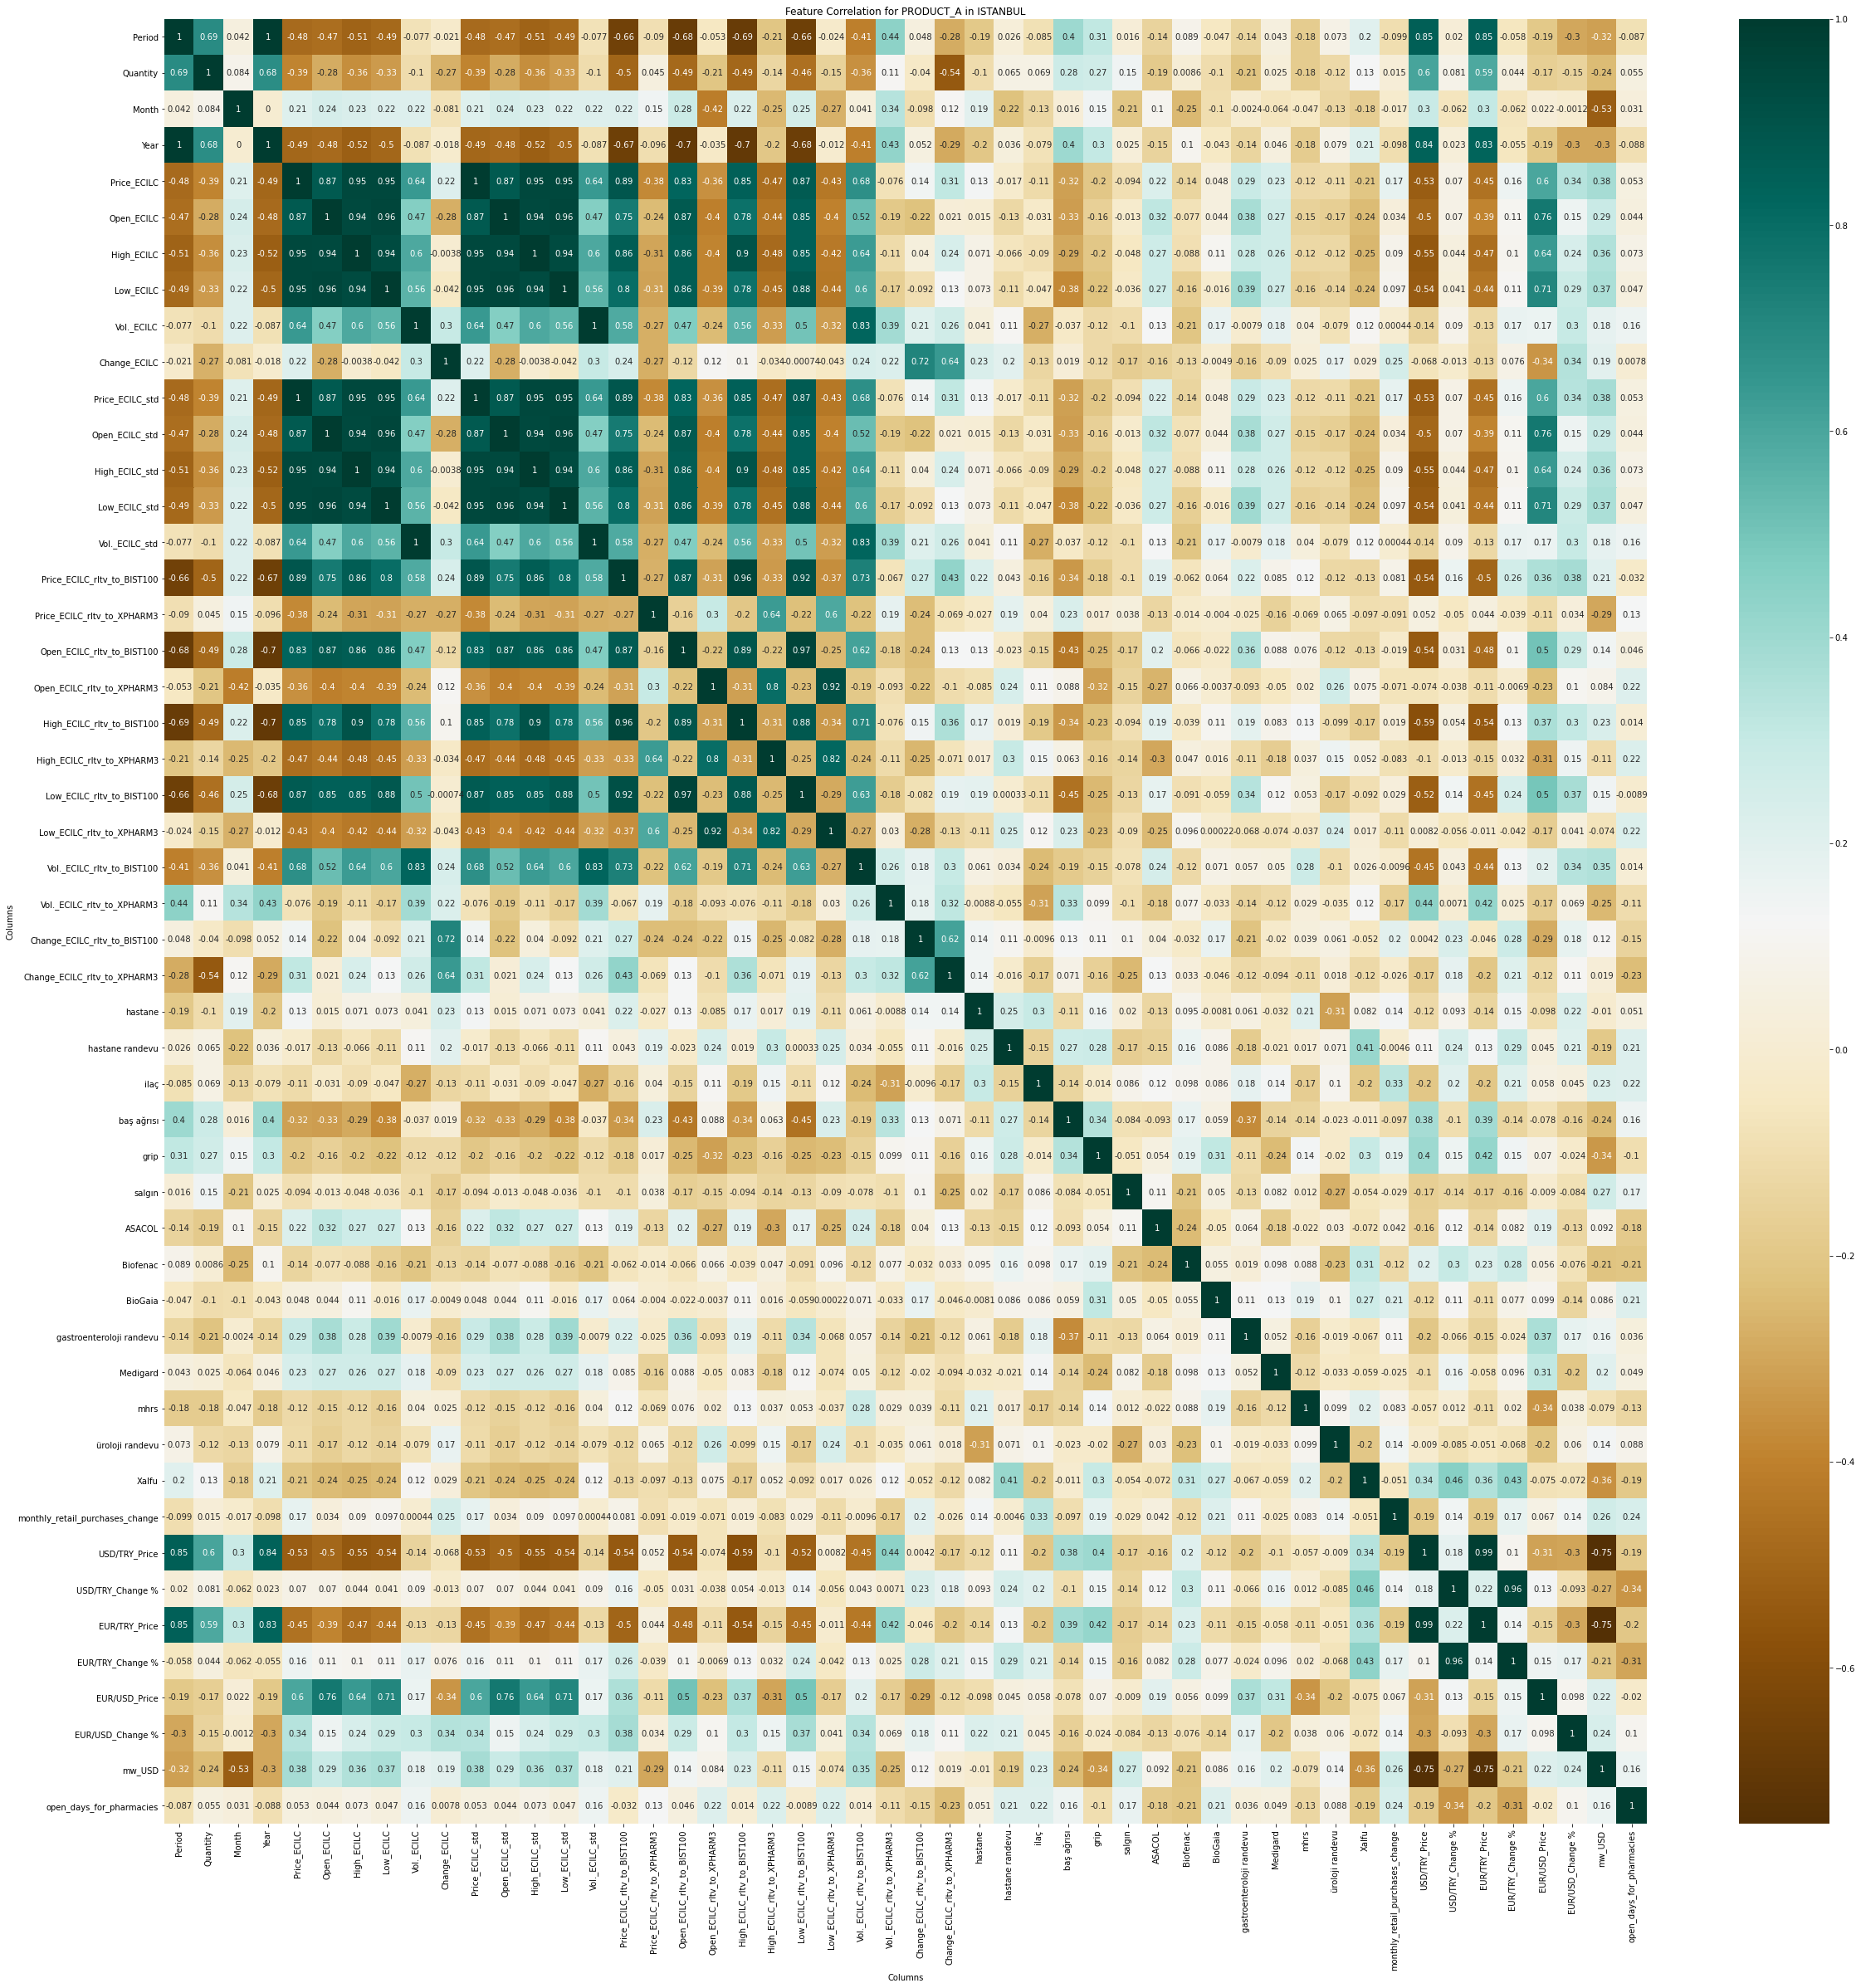

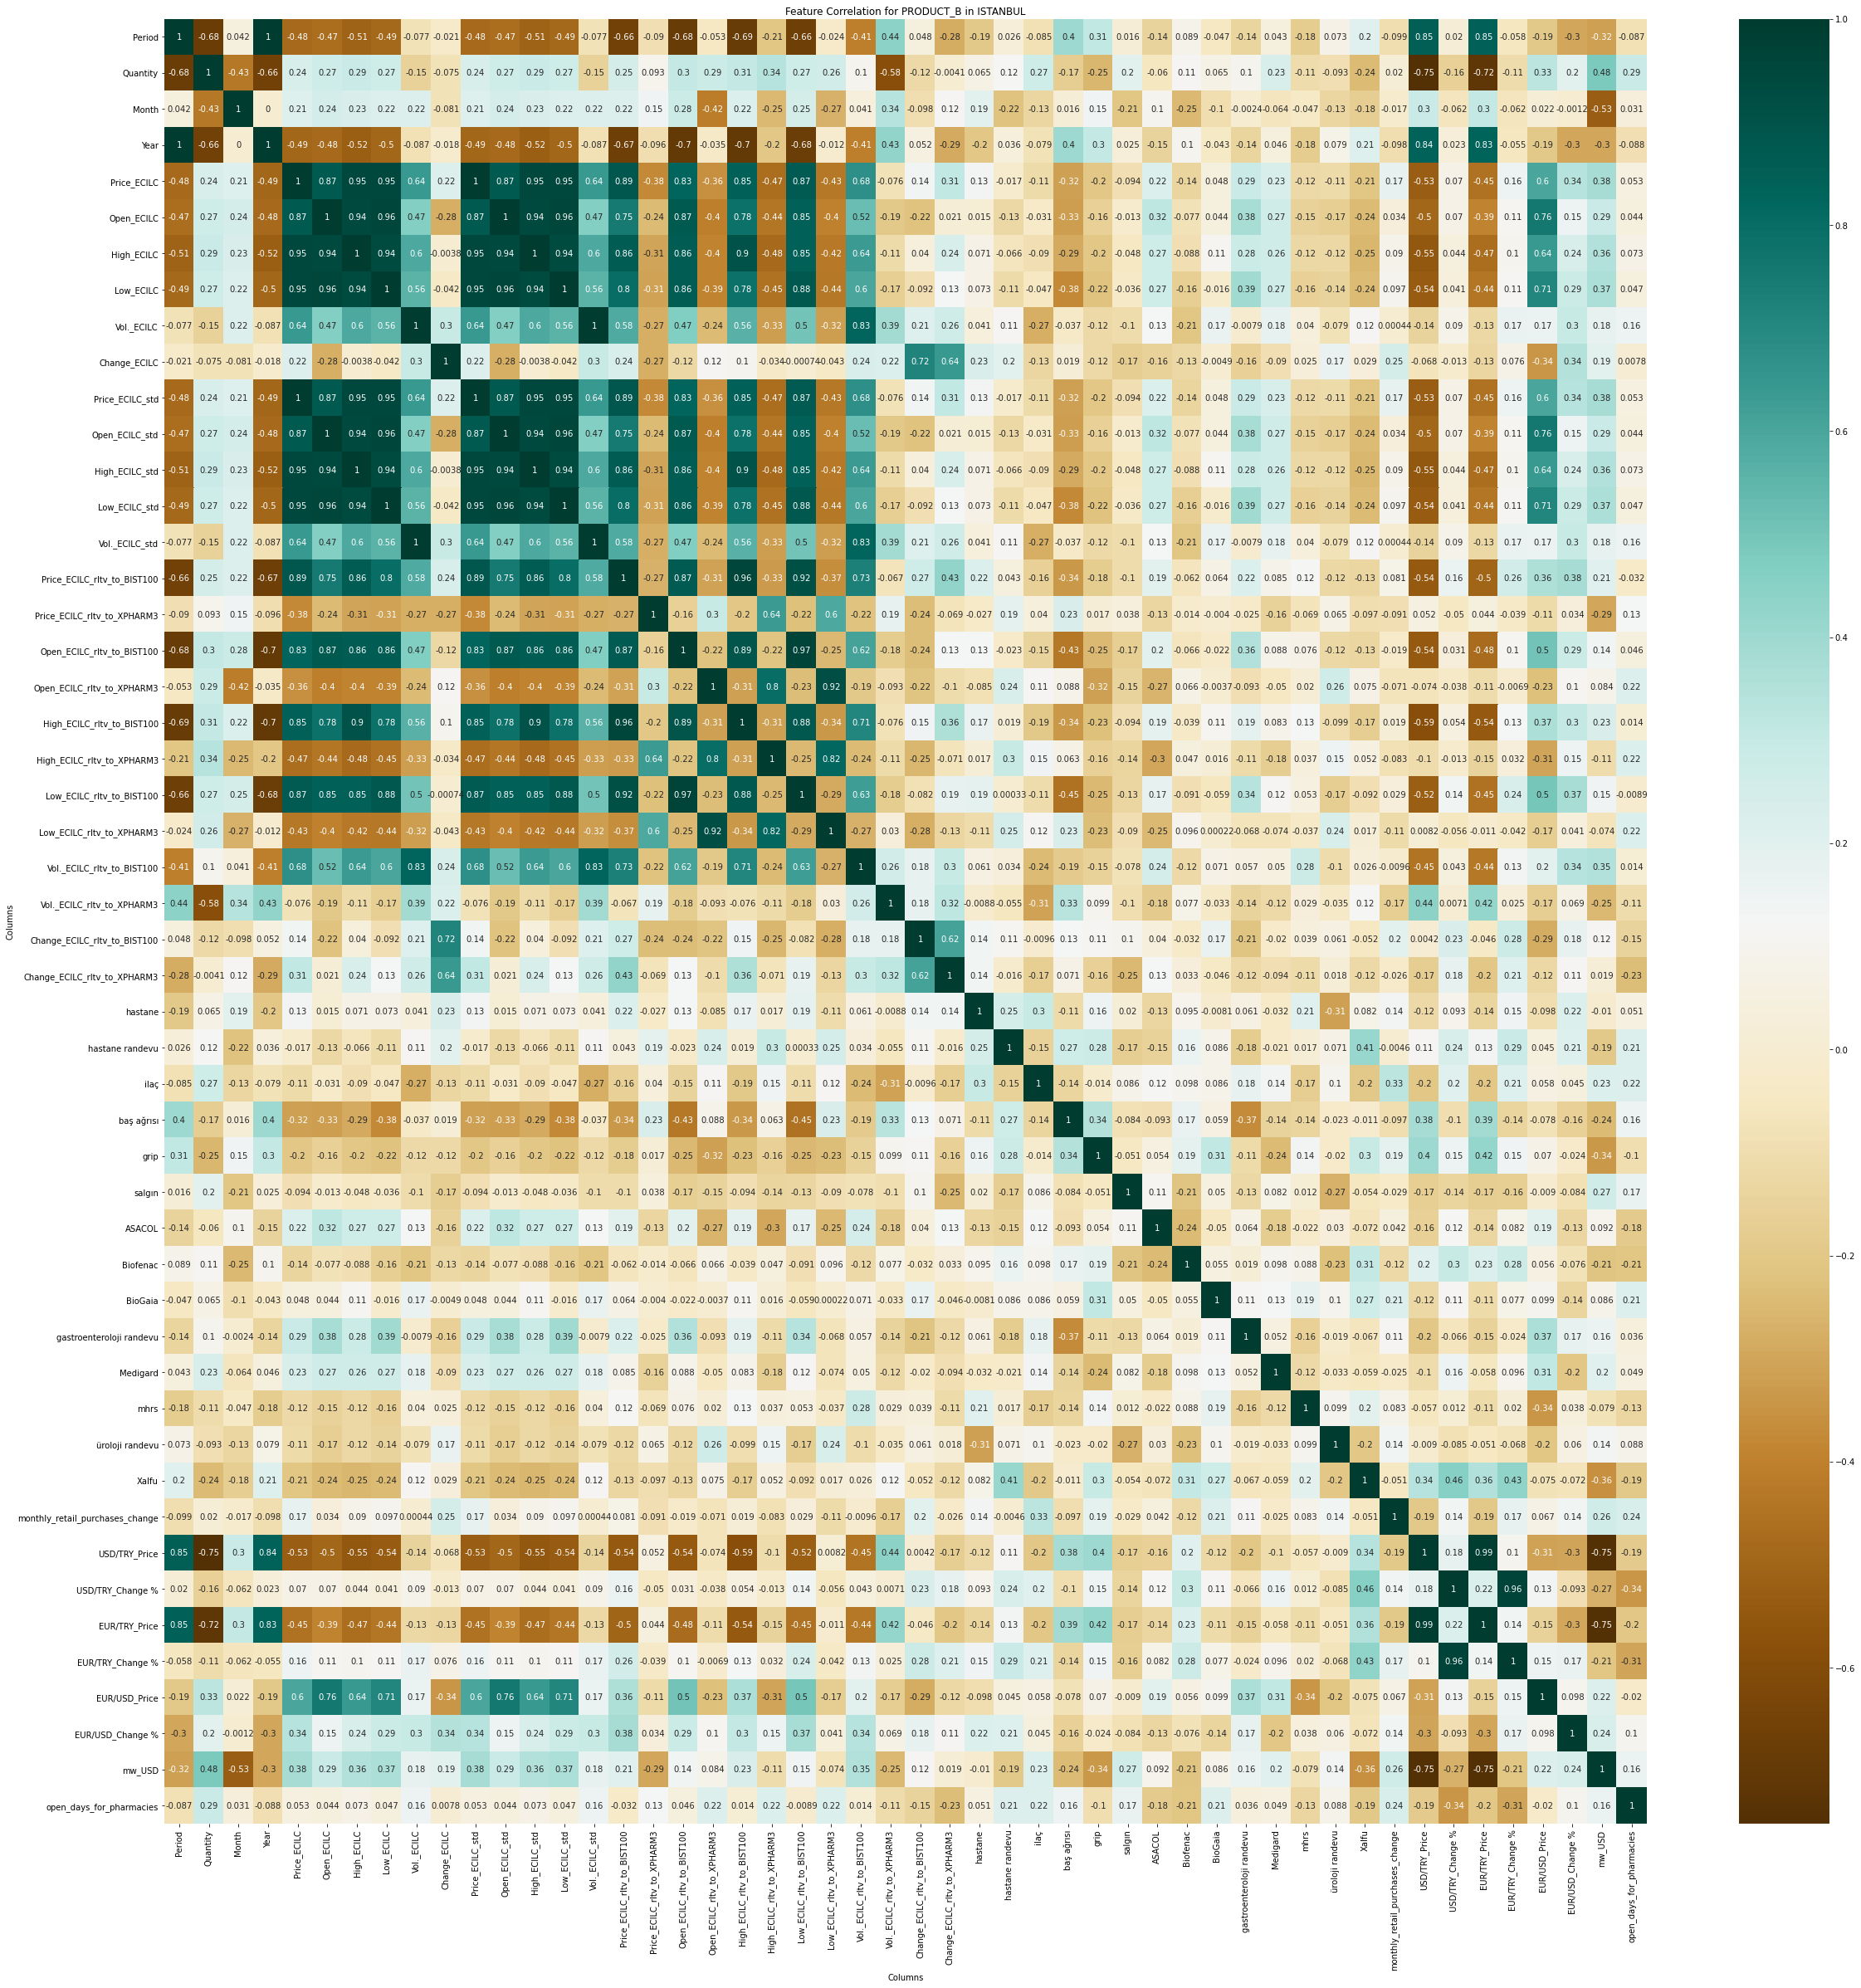

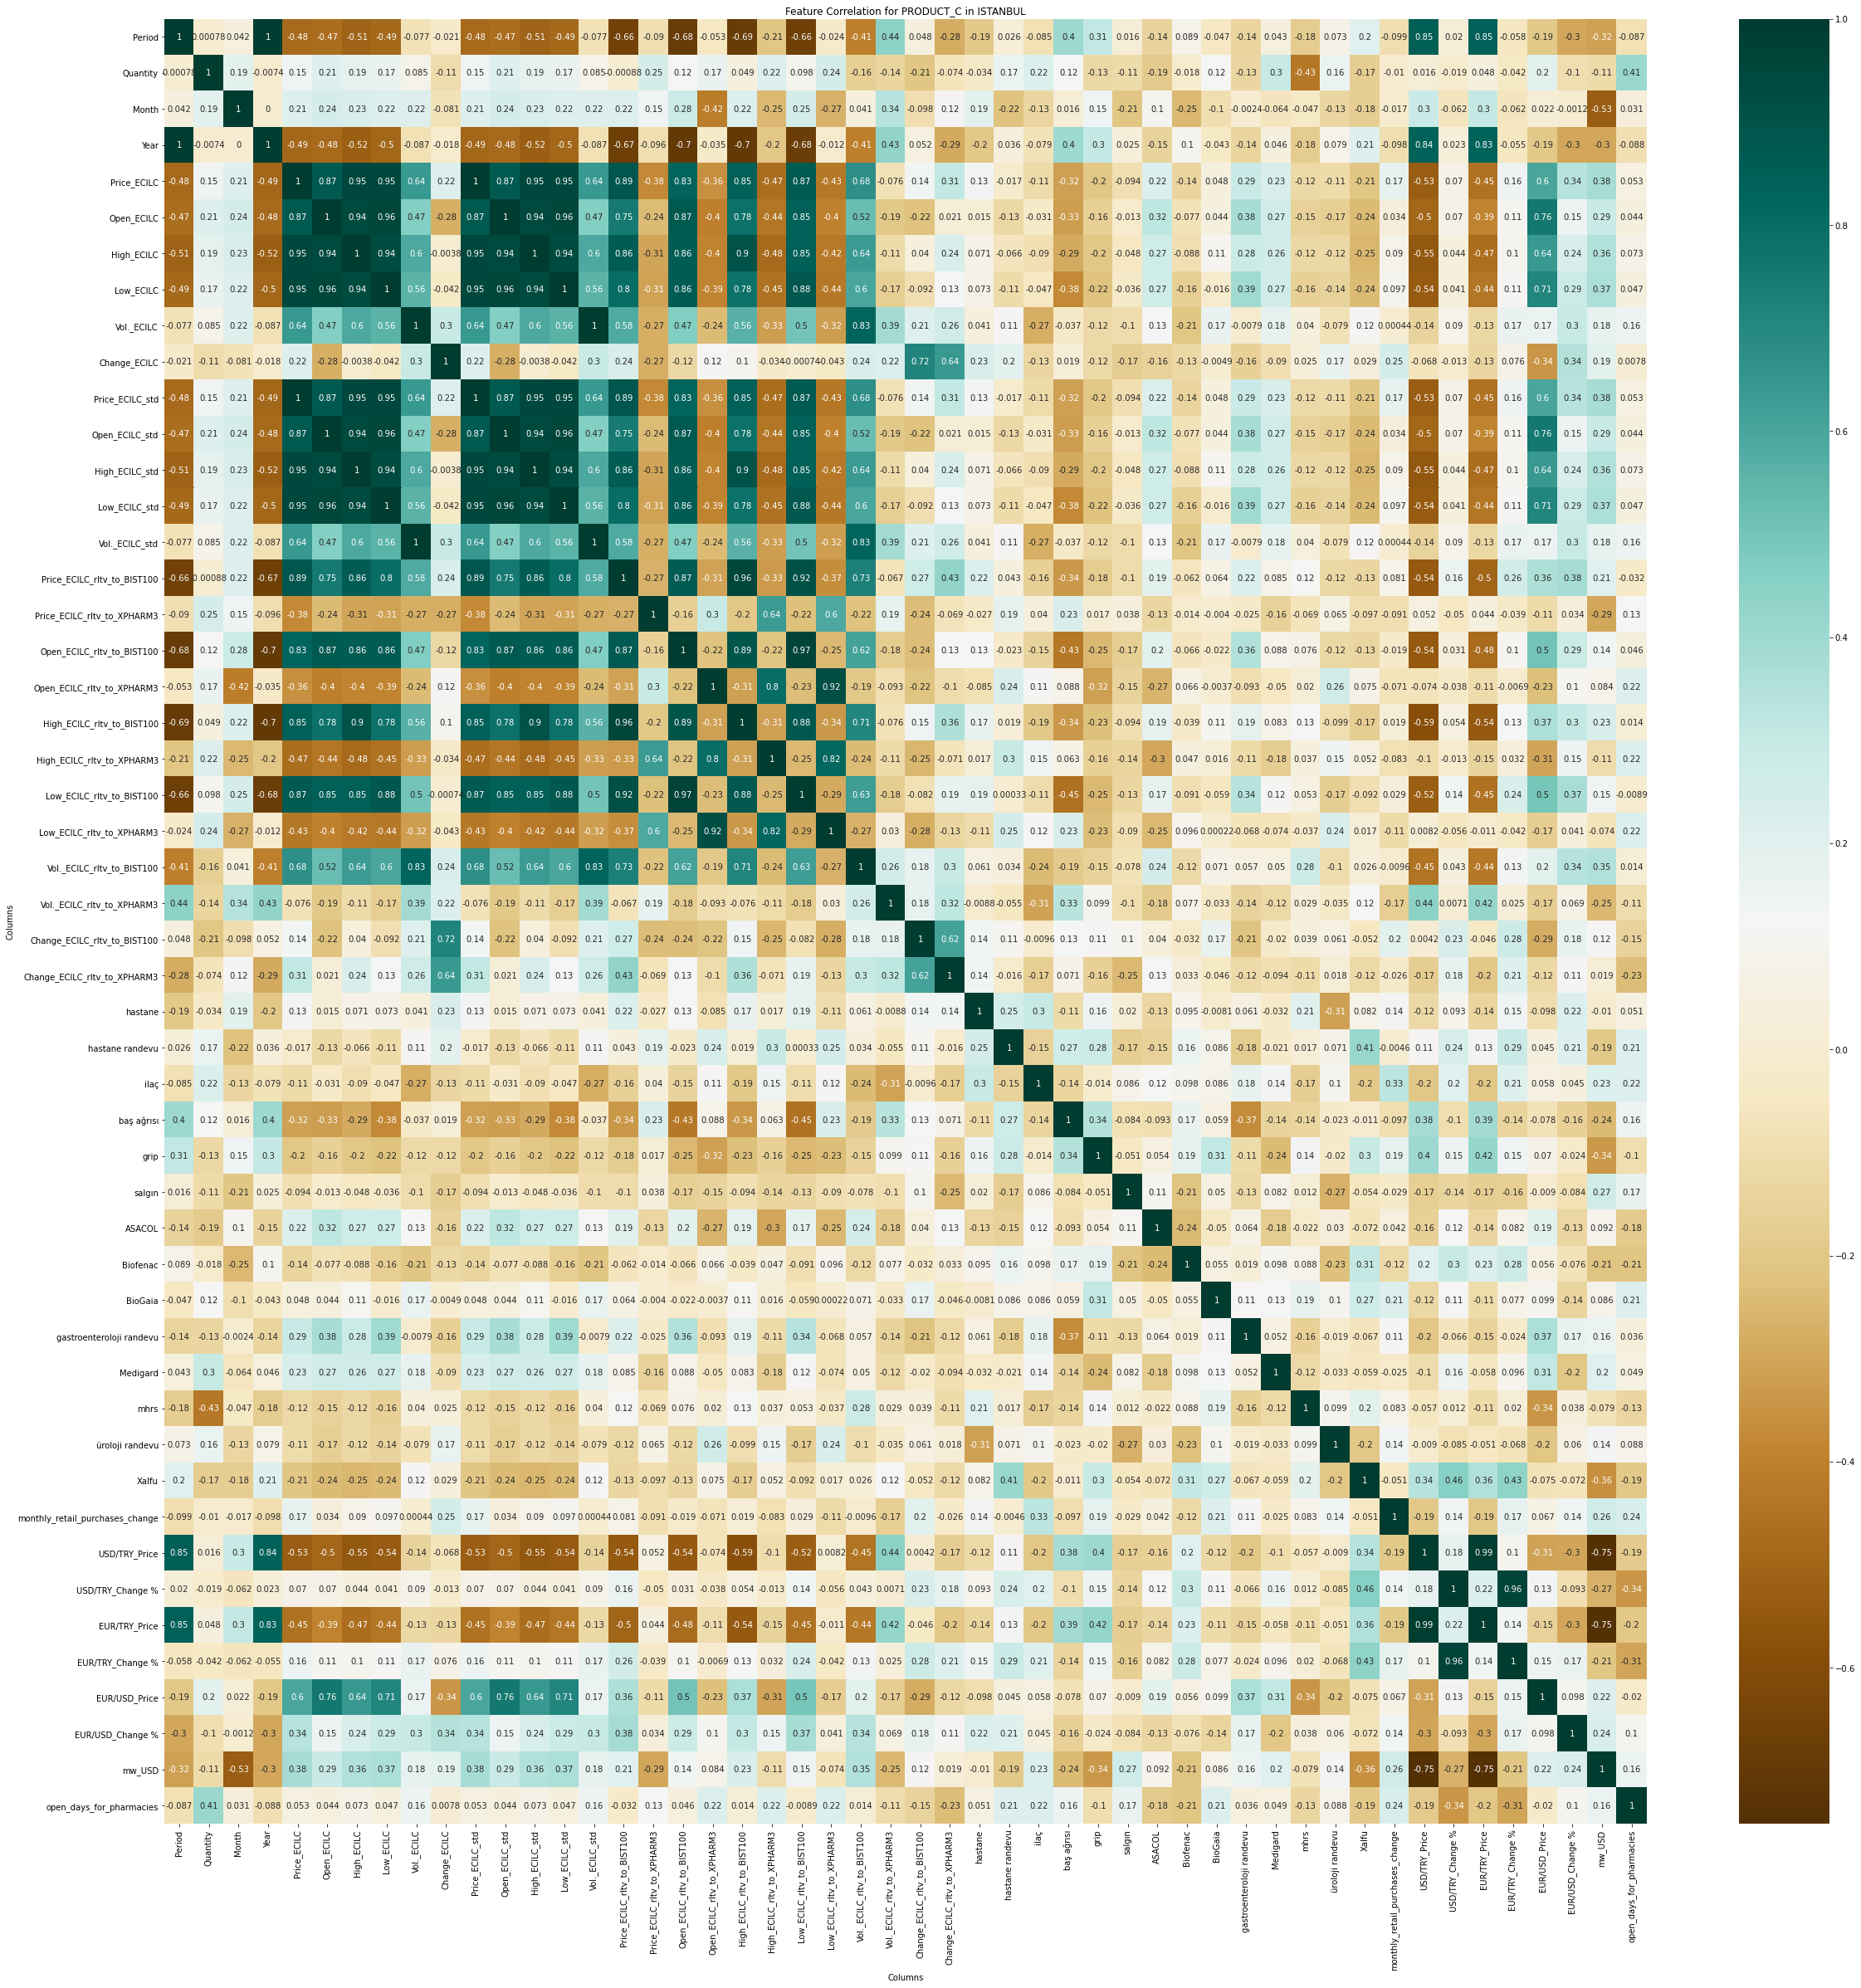

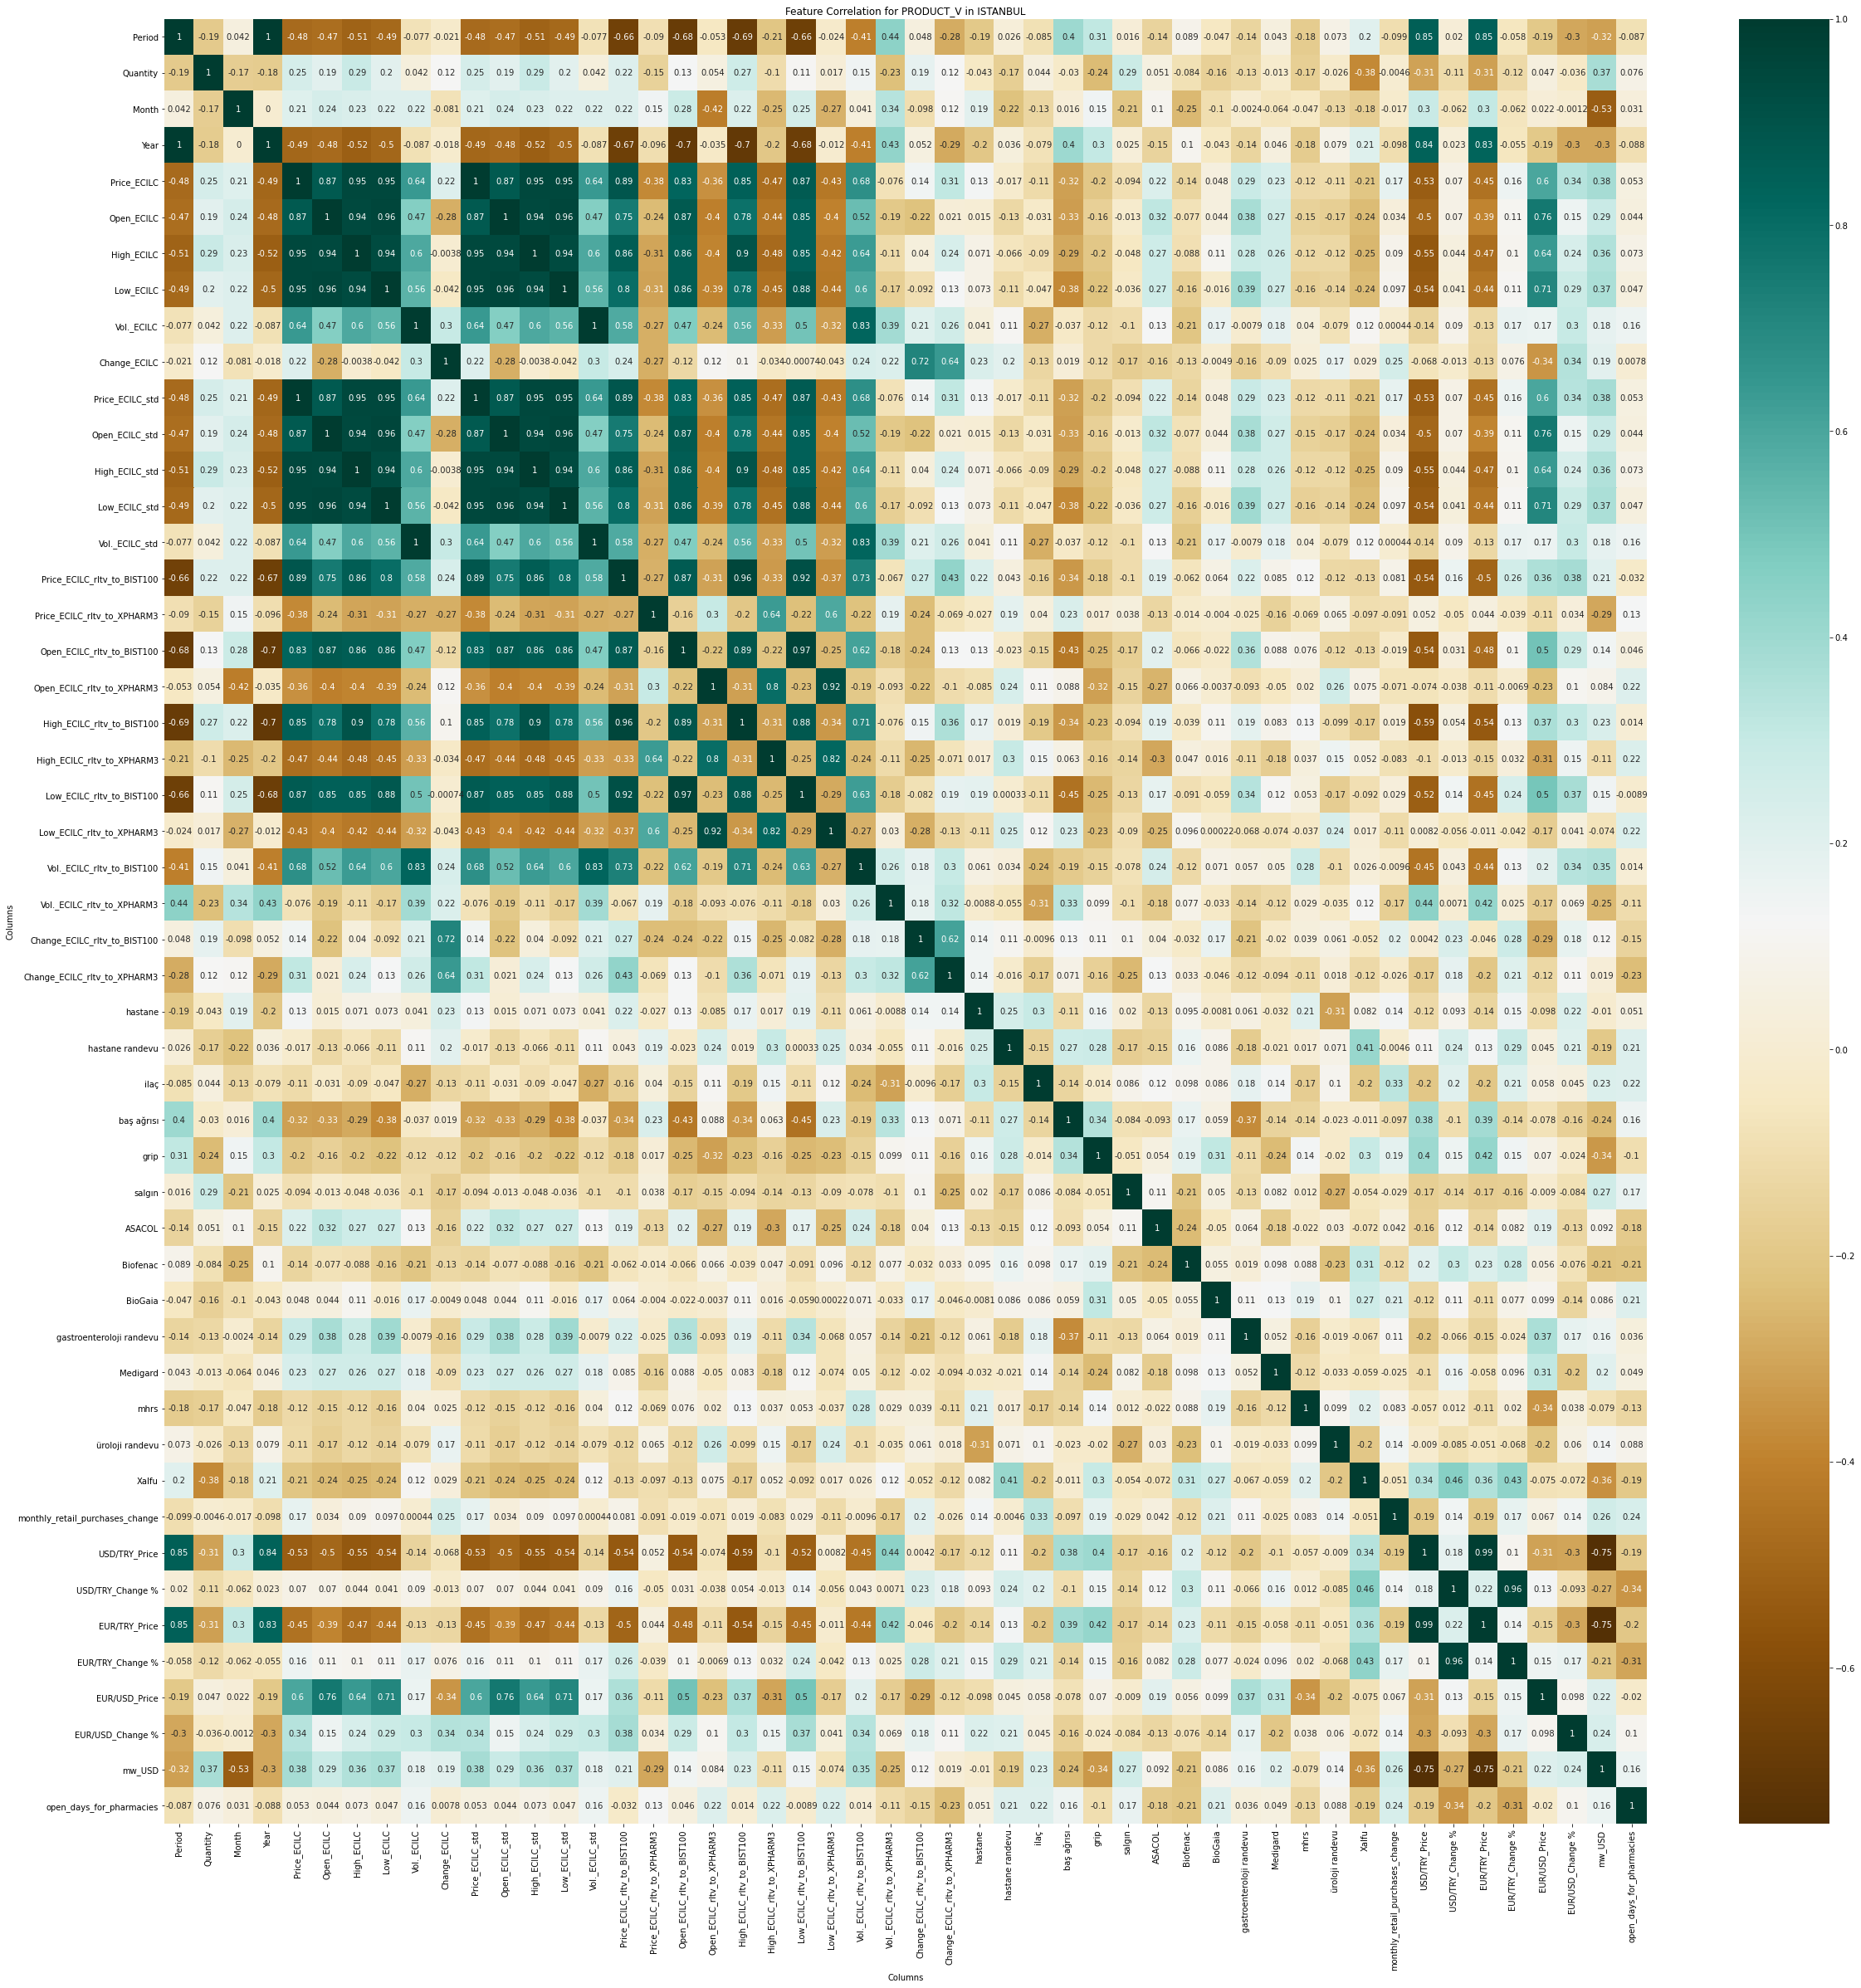

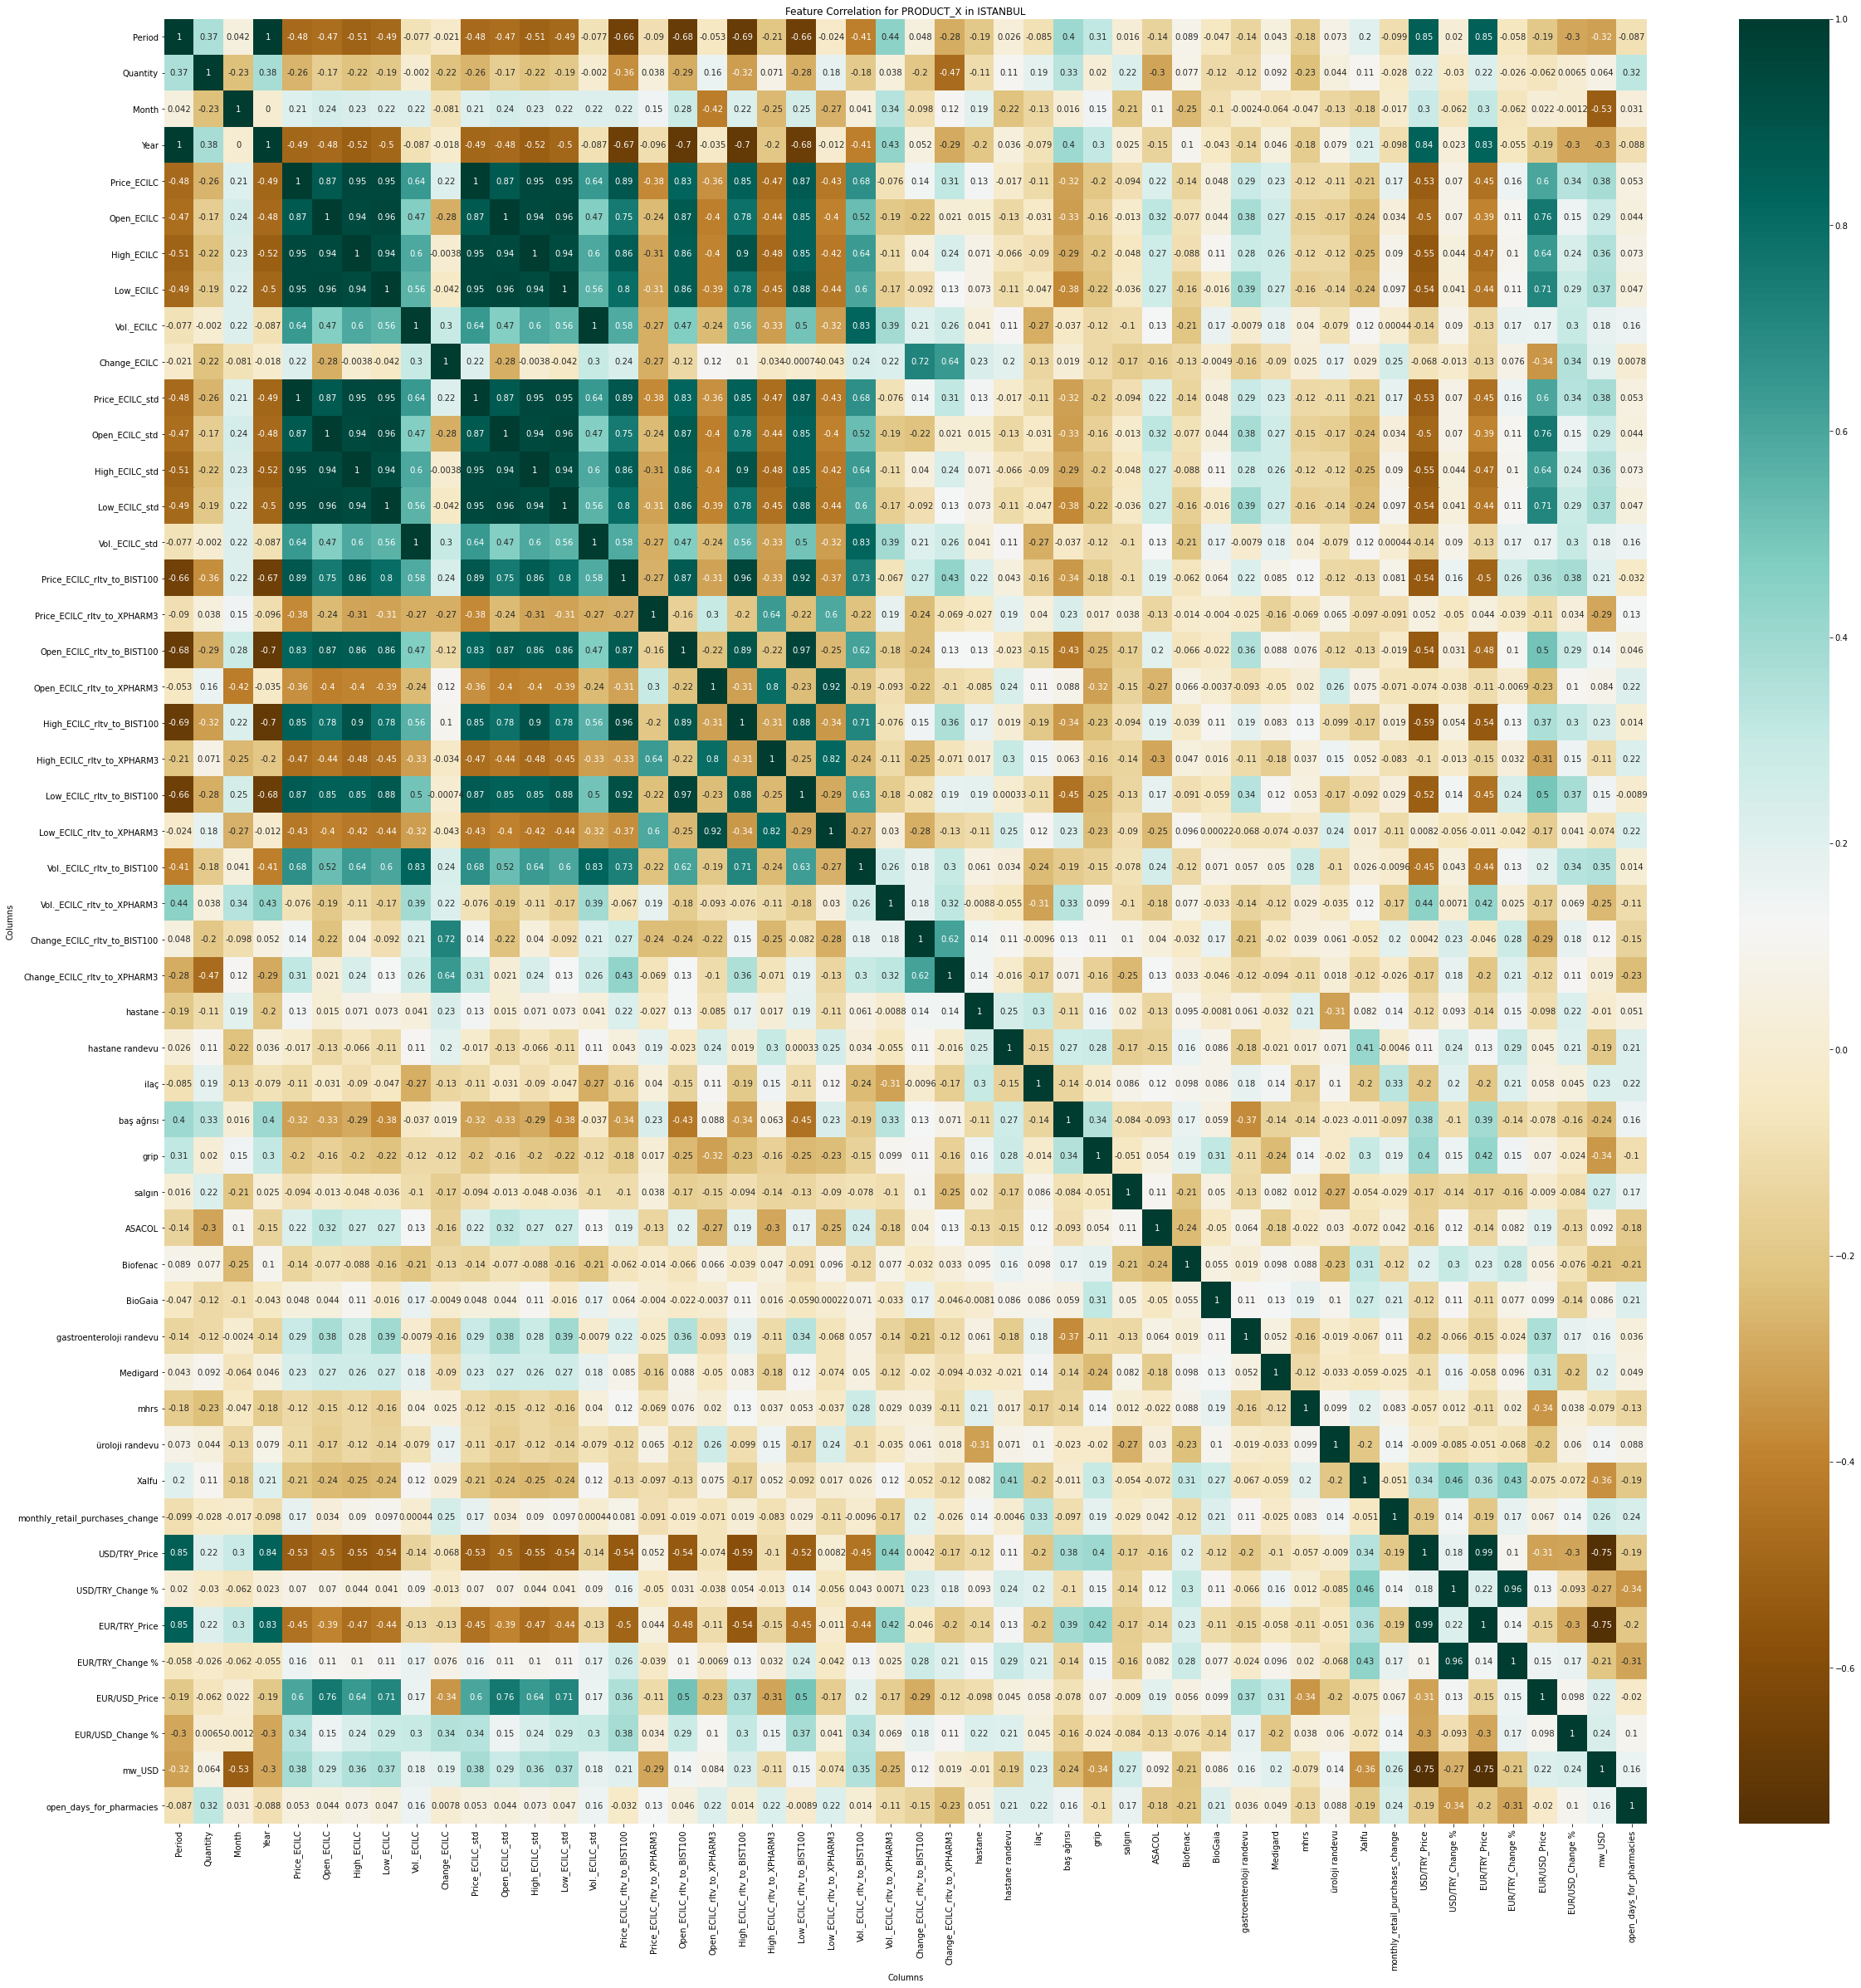

In [118]:
import seaborn as sns
for p in products:
    fig, ax = plt.subplots(figsize=(40,40))
    sns.heatmap(present_df_ist_time[present_df_ist_time.Product == p].corr(), annot=True, ax=ax, cmap='BrBG').set(title='Feature Correlation for '+p+' in ISTANBUL', xlabel='Columns', ylabel='Columns')
    plt.show()

### Mutual Correlation Between Features And The Quantity Sold

In [119]:
from sklearn.feature_selection import mutual_info_regression
for p in products:
    numerical_features = present_df_ist_time[present_df_ist_time.Product == p]._get_numeric_data().columns
    numerical_features = [x for x in numerical_features if x not in ['Period', 'Quantity']]
    #print(numerical_features)
    mut_info_num_vars = mutual_info_regression(present_df_ist_time[numerical_features], present_df_ist_time['Quantity'], n_neighbors=5)
    mut_info_num_vars_max_indices = np.flip(mut_info_num_vars.argsort())
    print('\n\n'+p)
    for i in mut_info_num_vars_max_indices:
        gap = ''
        for s in range(0,35-len(numerical_features[i])):
            gap += ' '
        print('{}:{}{}'.format(numerical_features[i], gap, mut_info_num_vars[i]))



PRODUCT_A
Year:                               0.08966750742756213
USD/TRY_Price:                      0.03720225383200093
Vol._ECILC_std:                     0.03712290001258811
Vol._ECILC:                         0.036411466506451884
Open_ECILC_rltv_to_XPHARM3:         0.025121282434184433
High_ECILC_rltv_to_XPHARM3:         0.0249610815426089
Low_ECILC_rltv_to_XPHARM3:          0.020406392194221024
Price_ECILC_rltv_to_XPHARM3:        0.017201446210124427
EUR/TRY_Price:                      0.015388454789328154
mw_USD:                             0.007012742884814571
Month:                              0.004480081812042069
Price_ECILC_std:                    0.0
Vol._ECILC_rltv_to_BIST100:         0.0
High_ECILC_std:                     0.0
Low_ECILC_std:                      0.0
Change_ECILC:                       0.0
Price_ECILC_rltv_to_BIST100:        0.0
Low_ECILC:                          0.0
Open_ECILC_rltv_to_BIST100:         0.0
High_ECILC:                         0.0
High_E



PRODUCT_X
Year:                               0.08790906038402735
USD/TRY_Price:                      0.0451268768861488
Vol._ECILC_std:                     0.03532642626593763
Vol._ECILC:                         0.03158986493636995
Open_ECILC_rltv_to_XPHARM3:         0.027112323097335356
High_ECILC_rltv_to_XPHARM3:         0.024799593770062245
Low_ECILC_rltv_to_XPHARM3:          0.021261155378625496
Price_ECILC_rltv_to_XPHARM3:        0.019527462835378095
EUR/TRY_Price:                      0.013447497956070809
baş ağrısı:                         0.0036770963350685193
mw_USD:                             0.0030236885253147605
Low_ECILC_rltv_to_BIST100:          0.0
High_ECILC_rltv_to_BIST100:         0.0
Open_ECILC_rltv_to_BIST100:         0.0
Price_ECILC_rltv_to_BIST100:        0.0
open_days_for_pharmacies:           0.0
Low_ECILC_std:                      0.0
Vol._ECILC_rltv_to_BIST100:         0.0
Open_ECILC_std:                     0.0
Price_ECILC_std:                    0.0
Chan

# Prediction

## Base Prediction With ARIMA

In [120]:
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


def print_base_prediction_with_arima_by_product(product='PRODUCT_V', p=5, d=1, q=0):
    present_df_turkey = present_df[present_df.Product==product].groupby(['Period'])['Quantity'].sum().reset_index()['Quantity']

    X = present_df_turkey
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    test = test.reset_index(drop=True)
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(p, d, q))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_squared_error(test, predictions)
    print('Test RMSE: %.3f' % math.sqrt(error))
    # plot
    pyplot.plot(test)
    pyplot.plot(predictions, color='red')
    pyplot.show()

/home/a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


predicted=7115.668618, expected=3782.000000
predicted=2126.679975, expected=8663.000000
predicted=8695.723167, expected=16596.000000
predicted=11802.693839, expected=17475.000000
predicted=11499.805602, expected=5883.000000
predicted=2715.493281, expected=7562.000000
predicted=14597.963260, expected=6370.000000
predicted=6169.606296, expected=2716.000000
predicted=8415.006819, expected=2102.000000
predicted=5978.867847, expected=12211.000000
predicted=11828.081937, expected=9364.000000
predicted=3362.668103, expected=8071.000000
predicted=8449.541730, expected=5048.000000
Test RMSE: 5558.045


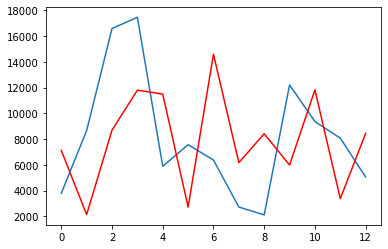

In [121]:
print_base_prediction_with_arima_by_product()

## Models

In [122]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor

### Get Dummies in order to convert categorical variables into binary numerical variables to ease the compuations and to hopefully boost the performance

In [123]:
df_dummies = pd.get_dummies(present_df[['Province', 'Year', 'Month']])
present_df = pd.merge(present_df, df_dummies, how="inner", left_index=True, right_index=True).drop(columns=['Province'])
present_df.head()

df_dummies = pd.get_dummies(data_integrated[['Province', 'Year', 'Month']])
data_integrated = pd.merge(data_integrated, df_dummies, how="inner", left_index=True, right_index=True).drop(columns=['Province'])
#data_integrated.head()

df_dummies = pd.get_dummies(future_df[['Province', 'Year', 'Month']])
future_df = pd.merge(future_df, df_dummies, how="inner", left_index=True, right_index=True).drop(columns=['Province'])
#future_df.head()

In [124]:
present_df.columns[35:55]

Index(['Biofenac', 'BioGaia', 'gastroenteroloji randevu', 'Medigard', 'mhrs',
       'üroloji randevu', 'Xalfu', 'GDP by City', 'life_expectancy',
       'population', 'pop_growth', 'pop_density', 'year_x',
       'pop_infants_and_toddlers', '80+_male', '65+_male', '50+_male', 'month',
       'monthly_retail_purchases_change', 'year_y'],
      dtype='object')

In [125]:
present_df.pop_density = present_df.pop_density.apply(lambda x: float(str(x).replace(' ','')))
data_integrated.pop_density = data_integrated.pop_density.apply(lambda x: float(str(x).replace(' ','')))
future_df.pop_density = future_df.pop_density.apply(lambda x: float(str(x).replace(' ','')))

In [126]:
future_df.head()

Period    Product  Quantity  Month_x  Year_x  Price_ECILC  Open_ECILC  \
14580  202001  PRODUCT_A         0        1    2020     0.566802    0.501274   
14581  202001  PRODUCT_B         0        1    2020     0.566802    0.501274   
14582  202001  PRODUCT_C         0        1    2020     0.566802    0.501274   
14583  202001  PRODUCT_V         0        1    2020     0.566802    0.501274   
14584  202001  PRODUCT_X         0        1    2020     0.566802    0.501274   

       High_ECILC  Low_ECILC  Vol._ECILC  ...  Province_SIVAS  \
14580    0.486395   0.646123    0.980042  ...               0   
14581    0.486395   0.646123    0.980042  ...               0   
14582    0.486395   0.646123    0.980042  ...               0   
14583    0.486395   0.646123    0.980042  ...               0   
14584    0.486395   0.646123    0.980042  ...               0   

       Province_TEKIRDAG  Province_TOKAT  Province_TRABZON  Province_TUNCELI  \
14580                  0               0                 0                 0   
14581                  0               0                 0                 0   
14582                  0               0                 0                 0   
14583                  0               0                 0                 0   
14584                  0               0                 0                 0   

       Province_USAK  Province_VAN  Province_YALOVA  Province_YOZGAT  \
14580              0             0                0                0   
14581              0             0                0                0   
14582              0             0                0                0   
14583              0             0                0                0   
14584              0             0                0                0   

       Province_ZONGULDAK  
14580                   0  
14581                   0  
14582                   0  
14583                   0  
14584                   0  

[5 rows x 146 columns]

In [127]:
present_df_product = {}

for p in present_df.Product.unique():
    present_df_product[p] = present_df[present_df.Product == p].drop(columns=['Product'])
    
data_integrated_product = {}

for p in data_integrated.Product.unique():
    data_integrated_product[p] = data_integrated[data_integrated.Product == p].drop(columns=['Product'])

future_df_product = {}

for p in future_df.Product.unique():
    future_df_product[p] = future_df[future_df.Product == p].drop(columns=['Product'])

In [128]:
def linear_regression_test(data):
    X = data.drop(['Quantity'], axis = 1)
    y = data.Quantity
    
    X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 0)
    lr = LinearRegression().fit(X_train,y_train)
    
    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)
    
    print(lr.score(X_test,y_test))

In [129]:
def linear_regression_with_polynomial_features_test(data):
    X = data.drop(['Quantity'], axis = 1)
    y = data.Quantity
    quad = PolynomialFeatures (degree = 2)
    x_quad = quad.fit_transform(X)
    
    X_train,X_test,y_train,y_test = train_test_split(x_quad,y, random_state = 0)
    
    plr = LinearRegression().fit(X_train,y_train)
    
    y_train_pred = plr.predict(X_train)
    y_test_pred = plr.predict(X_test)
    
    print(plr.score(X_test,y_test))

In [130]:
#linear_regression_with_polynomial_features_test()

In [146]:
from statistics import mean
def mean_absolute_percentage_error(actual_values, predictions):
    if len(actual_values) != len(predictions):
        print('actual values and predicitions are not equal')
    elif len(actual_values) == 0:
        print('actual values or predicitions is empty')
        return -1.0
    percentages = []
    for a, p in zip(actual_values, predictions):
        if a != 0:
            cr_percentage = abs((a-p)/a)
            percentages.append(cr_percentage)
    return mean(percentages)
    

In [189]:
def print_RMSE_score_by_products(data_with_preds):
    #data_with_preds = data_with_preds[int((-1*len(data_with_preds))/4):]
    
    data_with_preds = data_with_preds[['Period','Quantity','Predictions']].groupby(['Period'])['Quantity','Predictions'].sum().reset_index()
    print("\n\n"+p)
    print(data_with_preds)
    vals = data_with_preds.Quantity
    predictions = data_with_preds.Predictions
    rmse = math.sqrt(mean_squared_error(vals, predictions))
    mape = mean_absolute_percentage_error(data_with_preds.Quantity.tolist(), data_with_preds.Predictions.tolist())
    print("\nRMSE: %.2f" % (rmse))
    print("MAPE: %.2f" % (mape))
    
    print("data_with_preds: {}".format(data_with_preds.shape))
    
    df_series = data_with_preds
    df_series.Period = df_series.Period.apply(lambda x: str(x))
    print(df_series.dtypes)
    df_series = df_series.set_index('Period')
    ax1 = df_series.plot()
    


In [190]:
def random_forest_regressor_test(data, future_data=None, n_estimators=120, test_size = 0.25, max_depth=None, min_samples_leaf=1, my_shuffle=False, func_shuffle=False, future=False):
    
    if my_shuffle:
        data = data.sample(frac=1).reset_index(drop=True)
        
    if future:
        test_size = 0.001
    
    X = data.drop(['Quantity'], axis = 1)
    y = data.Quantity
    
    X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 0,  test_size=test_size)
    
    
    forest = RandomForestRegressor(n_estimators = n_estimators,
                                   criterion = 'mse',
                                   max_depth = max_depth,
                                   min_samples_leaf = min_samples_leaf,
                                   random_state = 1,
                                   n_jobs = -1)
    forest.fit(X_train,y_train)
    forest_train_pred = forest.predict(X_train)
    forest_test_pred = forest.predict(X_test)
    
    predictions = forest.predict(X)
    data_with_predictions = data.copy()
    data_with_predictions['Predictions'] = predictions
    
    
    
    data_with_future_predictions = pd.DataFrame(columns=data_with_predictions.columns)
    if future:
        X_future = future_data.drop(['Quantity'], axis = 1)
        future_predictions = forest.predict(X_future)
        data_with_future_predictions = future_data.copy()
        data_with_future_predictions['Predictions'] = future_predictions
    
    
    
    print('RMSE train data: %.2f, RMSE test data: %.2f' % (
    math.sqrt(mean_squared_error(y_train, forest_train_pred)),
    math.sqrt(mean_squared_error(y_test, forest_test_pred))))
    print('R2 train data: %.2f, R2 test data: %.2f' % (
    r2_score(y_train, forest_train_pred),
    r2_score(y_test, forest_test_pred)))
    print('\n')
    if future:
        return data_with_predictions, data_with_future_predictions
    else:
        return data_with_predictions

In [191]:
#linear_regression_test()

In [192]:
# for p in products:
#     data_with_predictions = random_forest_regressor_test(present_df_product[p])



PRODUCT_A:
RMSE train data: 109.38, RMSE test data: 167.28
R2 train data: 0.96, R2 test data: 0.88




PRODUCT_A
    Period  Quantity   Predictions
0   201701     12289  14065.743400
1   201702     11583  14189.024435
2   201703     12040  14098.052621
3   201704     10902  14090.917025
4   201705     12201  14066.842832
5   201706     11453  13989.989589
6   201707     12224  14149.841197
7   201708     12313  14078.352543
8   201709     14241  14115.544901
9   201710     13246  14069.272473
10  201711     12974  14105.416814
11  201712     13628  14101.045654
12  201801     15246  15408.319691
13  201802     14274  15431.439468
14  201803     14727  15504.856429
15  201804     13150  15419.679597
16  201805     15371  15759.517998
17  201806     14963  15506.542190
18  201807     14982  15466.997494
19  201808     14634  15739.745070
20  201809     17602  15931.591367
21  201810     16235  15996.323764
22  201811     14227  15580.086582
23  201812     18729  16071.248097
24  201901

/home/a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


RMSE train data: 748.90, RMSE test data: 798.95
R2 train data: 0.94, R2 test data: 0.92




PRODUCT_B
    Period  Quantity    Predictions
0   201701    152632  141959.236374
1   201702    149843  139318.602081
2   201703    188694  142411.212685
3   201704    151354  138558.523987
4   201705    167424  141265.621219
5   201706    120641  136436.119697
6   201707    130893  136106.731704
7   201708    146244  135358.958763
8   201709    184264  141694.939817
9   201710    144721  138183.529761
10  201711    151072  138128.646521
11  201712    148818  138258.283207
12  201801    157414  141648.959569
13  201802    150846  138944.175743
14  201803    164642  140455.896969
15  201804    112746  133132.102341
16  201805    137825  133217.288818
17  201806    125701  130306.563830
18  201807    110656  124412.732526
19  201808     65064   94405.601731
20  201809    136144  101481.990642
21  201810     98061   99169.218637
22  201811    136443  123192.508908
23  201812     93656  103666.29372

/home/a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


RMSE train data: 152.86, RMSE test data: 178.32
R2 train data: 0.99, R2 test data: 0.99




PRODUCT_C
    Period  Quantity   Predictions
0   201701     52767  52472.558234
1   201702     46387  51418.791593
2   201703     46790  51078.183729
3   201704     42640  50866.179455
4   201705     45626  51000.328015
5   201706     43395  50496.675997
6   201707     47277  51568.028212
7   201708     52361  51506.911155
8   201709     55425  52496.587526
9   201710     56254  54085.254722
10  201711     55067  53605.897190
11  201712     56618  53659.221801
12  201801     62320  55112.108778
13  201802     55892  53827.445583
14  201803     49577  52550.727468
15  201804     47229  52154.733466
16  201805     52516  52927.675515
17  201806     51794  51759.064840
18  201807     52946  52034.606895
19  201808     60434  52456.215210
20  201809     54459  52256.977662
21  201810     62924  55799.358739
22  201811     55988  54097.554170
23  201812     59641  54551.479550
24  201901     54832  5

/home/a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


RMSE train data: 221.15, RMSE test data: 356.94
R2 train data: 0.82, R2 test data: 0.52




PRODUCT_V
    Period  Quantity   Predictions
0   201701      4905   8127.785907
1   201702     11635   9075.977212
2   201703     13120   9518.389104
3   201704      6278   8091.379845
4   201705     12560  10470.870810
5   201706     14104  11076.284928
6   201707      3379  10019.383249
7   201708      8148  10353.920403
8   201709     18387  12741.660244
9   201710     21400  11913.677448
10  201711     14364  10766.774755
11  201712      8422   9477.110767
12  201801      4743   9079.795418
13  201802     12848   9946.578987
14  201803     15225   9418.437545
15  201804      7750   9126.603665
16  201805      6795   8568.346377
17  201806      7782   7521.947213
18  201807      4319   7880.220603
19  201808      3835   7448.057580
20  201809      8223   7900.193282
21  201810      5523   7349.650948
22  201811      4911   7640.931393
23  201812      3782   7194.861066
24  201901      8663   

/home/a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


RMSE train data: 113.12, RMSE test data: 131.11
R2 train data: 0.92, R2 test data: 0.88




PRODUCT_X
    Period  Quantity   Predictions
0   201701     19375  19342.800112
1   201702     18863  19209.810965
2   201703     19959  19278.677016
3   201704     17891  19027.314277
4   201705     19651  16318.858929
5   201706     15839  18877.244483
6   201707     16534  18979.046976
7   201708     15378  18884.671683
8   201709     16552  18945.455603
9   201710     19671  19162.563209
10  201711     20365  19191.356748
11  201712     21068  19340.265550
12  201801     20617  19694.967528
13  201802     20509  19618.616226
14  201803     19925  19633.861726
15  201804     18261  19516.232549
16  201805     20182  19529.574008
17  201806     17336  19356.986366
18  201807     18370  19357.026956
19  201808     15598  19117.642330
20  201809     18808  19388.762906
21  201810     20233  19456.283352
22  201811     17608  19518.461145
23  201812     20219  19582.485054
24  201901     26717  2

/home/a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


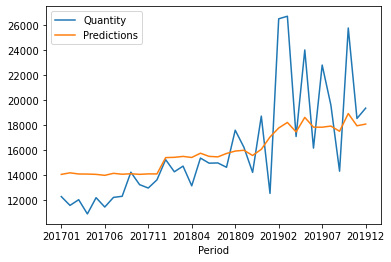

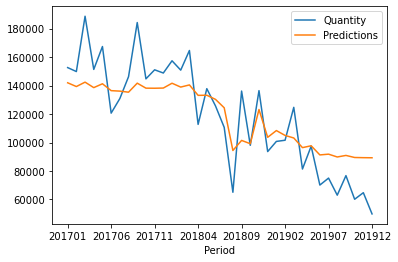

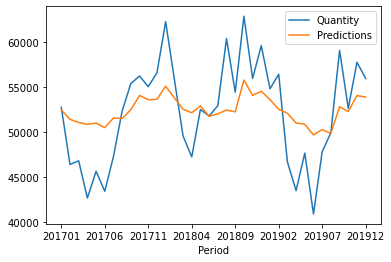

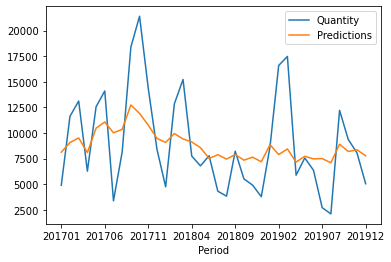

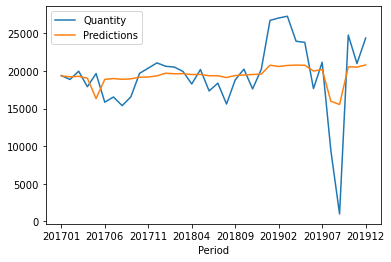

In [193]:
# present_df_product
# data_integrated_product
# future_df_product
max_depth_for_products = [3, 4, 4, 3, 4]
min_samples_leaf_for_products = [1, 1, 1, 1, 1]
for i,p in enumerate(products):
        print("\n\n"+p+":")
        data_with_predictions = random_forest_regressor_test(present_df_product[p], future_df_product[p], max_depth=max_depth_for_products[i], min_samples_leaf=min_samples_leaf_for_products[i], future=False)
        # , data_with_future_predictions
        print_RMSE_score_by_products(data_with_predictions)
        #print("\nFUTURE > "+p)
        #print_RMSE_score_by_products(data_with_future_predictions)

## LSTM

In [147]:
import keras
import tensorflow as tf
#from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout

import statsmodels.api as sm
import statsmodels.tsa.api as smt


In [148]:
def lstm_model(data, future_data, future=False):
    # Call helper functions to create X & y and scale data
    train_data = data[:int(-1*len(data)/12)]
    test_data = data[int(-1*len(data)/12):]
    
    
    if future:
        train_data = data
        test_data = future_data
    
    
    
    
    #X = data.drop(['Quantity'], axis = 1)
    #y = data.Quantity
    
    X_train = train_data.drop(['Quantity'], axis = 1)
    X_test = test_data.drop(['Quantity'], axis = 1)
    y_train = train_data.Quantity
    y_test = test_data.Quantity
    
    #X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 0)
    
    
    
    X_train,X_test,y_train,y_test = X_train.values, X_test.values, y_train.values, y_test.values
    
    
    #X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)  
    
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    
    
    
    # Build LSTM
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], 
                                         X_train.shape[2]), 
                                         stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=2, batch_size=1, verbose=1, 
              shuffle=False)
    
    
    
    
    
    
    preds_test = model.predict(X_test, batch_size=1)
    preds_train = model.predict(X_train, batch_size=1)
    
    
    rmse = math.sqrt(mean_squared_error(y_test, preds_test))
    print("\nRMSE: %.2f" % (rmse))
    
    
    test_data['Predictions'] = preds_test
    print_RMSE_score_by_products(test_data)
    
    # Call helper functions to undo scaling & create prediction df
    #original_df = pd.read_csv(temp_data_dir) #load_data('../data/monthly_data.csv')
    #unscaled_train = undo_scaling(preds_train, X_train, scaler_object, lstm=True)
    #unscaled_test = undo_scaling(preds_test, X_test, scaler_object, lstm=True)
    #unscaled_df_train = predict_df(unscaled_train, original_df)    
    #unscaled_df_test = predict_df(unscaled_test, original_df)    
    # Call helper functions to print scores and plot results
    #get_scores(unscaled_df, original_df, 'LSTM')
    #plot_results(unscaled_df, original_df, 'LSTM')
    
    
    
    
    #predictions = pd.Series(unscaled_train.tolist()+unscaled_test.tolist())
    #data_with_predictions = data.copy()
    #data_with_predictions['Predictions'] = predictions
    
    
    return preds_train, preds_test, train_data, test_data #data_with_predictions

In [149]:
def lstm_modelv(data, future_data, future=False):
    # Call helper functions to create X & y and scale data
    train_data = data[:int(-1*len(data)/12)]
    test_data = data[int(-1*len(data)/12):]
    
    
    if future:
        train_data = data
        test_data = future_data
    
    
    
    X_train = train_data.drop(['Quantity'], axis = 1)
    X_test = test_data.drop(['Quantity'], axis = 1)
    y_train = train_data.Quantity
    y_test = test_data.Quantity
    
    #X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 0)
    
    
    
    X_train,X_test,y_train,y_test = X_train.values, X_test.values, y_train.values, y_test.values
    
    
    #X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)  
    
    
    
    
    
    # Build LSTM
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], 
                                         X_train.shape[2]), 
                                         stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=40, batch_size=1, verbose=1, 
              shuffle=False)
    
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    
    preds_test = model.predict(X_test, batch_size=1)
    preds_train = model.predict(X_train, batch_size=1)
    
    
    
    
    
    
    
    rmse = math.sqrt(mean_squared_error(y_test, preds_test))
    print("\nRMSE: %.2f" % (rmse))
    
    
    test_data['Predictions'] = preds_test
    print_RMSE_score_by_products(test_data)
    
    
    
    return preds_train, preds_test, train_data, test_data #data_with_predictions

In [150]:
for p in products:
    if p == 'PRODUCT_A':
        print("\n\n"+p)
        p_train, p_test, train_data, test_data = lstm_model(present_df_product[p], future_df_product[p], future=True)
        break



PRODUCT_A
Epoch 1/2
2916/2916 [==============================] - 3s 1ms/step - loss: 302201.3787
Epoch 2/2
2916/2916 [==============================] - 3s 1ms/step - loss: 297659.0198


ValueError: Error when checking input: expected lstm_2_input to have shape (1, 144) but got array with shape (1, 145)

In [ ]:
def scale_data(train_set, test_set):
    """Scales data using MinMaxScaler and separates data into X_train, y_train,
    X_test, and y_test.
    Keyword Arguments:
    -- train_set: dataset used to train the model
    -- test_set: dataset used to test the model
    """

    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)

    # reshape training set

    train_set = train_set.values.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)

    # reshape test set
    test_set = test_set.values.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)

    
    
    X_train, y_train = train_set_scaled[:, 2:], train_set[:, 1:2].ravel()
    X_test, y_test = test_set_scaled[:, 2:], test_set[:, 1:2].ravel()
    
    #X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    #X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()

    return X_train, y_train, X_test, y_test, scaler

In [ ]:
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):
    """For visualizing and comparing results, undoes the scaling effect on
    predictions.
    Keyword arguments:
    -- y_pred: model predictions
    -- x_test: features from the test set used for predictions
    -- scaler_obj: the scaler objects used for min-max scaling
    -- lstm: indicate if the model run is the lstm. If True, additional
             transformation occurs
    """
    
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0, len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index], x_test[index]],
                                            axis=1))
    
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0],
                                          pred_test_set.shape[2])
    
    print("pred_test_set.shape: {}".format(pred_test_set.shape))
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted


In [ ]:
def predict_df(unscaled_predictions, original_df, is_arima=False, is_test=True):
    """Generates a dataframe that shows the predicted sales for each day
    for plotting results.
    Keyword arguments:
    -- unscaled_predictions: the model predictions that do not have min-max or
                             other scaling applied
    -- original_df: the original daily sales dataframe
    """
    
    #create dataframe that shows the predicted sales
    result_list = []
    #sales_dates = list(original_df[-29:].date)
    sales_dates = list(original_df[-29:].index)
    
    act_sales = list(original_df[-29:].sales)

    for index in range(0, len(unscaled_predictions)):
        result_dict = {}
        
        if not is_arima:
            result_dict['pred_value'] = int(unscaled_predictions[index][0] +
                                        act_sales[index])
        else:
            result_dict['pred_value'] = int(unscaled_predictions.iloc[index][0] +
                                        act_sales[index])
            
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)

    df_result = pd.DataFrame(result_list)
    df_result.set_index(["date"],drop=True, inplace=True)
    return df_result


In [ ]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    """Prints the root mean squared error, mean absolute error, and r2 scores
    for each model. Saves all results in a model_scores dictionary for
    comparison.
    Keyword arguments:
    -- unscaled_predictions: the model predictions that do not have min-max or
                             other scaling applied
    -- original_df: the original daily sales dataframe
    -- model_name: the name that will be used to store model scores
    """
    rmse = np.sqrt(mean_squared_error(original_df.sales[-28:], unscaled_df.pred_value[-28:]))
    mae = mean_absolute_error(original_df.sales[-28:], unscaled_df.pred_value[-28:])
    r2 = r2_score(original_df.sales[-28:], unscaled_df.pred_value[-28:])
    
    rmsse_score = rmsse(np.array(ground_truth), np.array(unscaled_df), np.array(train_series), 0)
    
    model_scores[model_name] = [rmse, mae, r2, rmsse_score]
    
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")
    print(f"rmsse: {rmsse_score}")


In [ ]:
def plot_results(results, original_df, model_name):
    """Plots predictions over original data to visualize results. Saves each
    plot as a png.
    Keyword arguments:
    -- results: a dataframe with unscaled predictions
    -- original_df: the original daily sales dataframe
    -- model_name: the name that will be used in the plot title
    """
    fig, ax = plt.subplots(figsize=(25, 7))

    original_df_plot = original_df.iloc[-28:, :]
    sns.lineplot(original_df_plot.index, original_df_plot.sales, data=original_df_plot, ax=ax,
                 label='Original', color='mediumblue')

    sns.lineplot(results.index, results.pred_value, data=results, ax=ax,
                 label='Predicted', color='red')
    ax.set(xlabel="Date",
           ylabel="Sales",
           title=f"{model_name} Sales Forecasting Prediction")
    ax.legend()
    sns.despine()

## Resources & References

1. Coordinates json file for the cities of Turkey:
   - https://github.com/cihadturhan/tr-geojson/tree/master/geo
2. An open source geographical heat map library used for data visualization
   - https://github.com/python-visualization/folium
3. ECILC / eczacibasi ilac monthly historical data
   - https://www.investing.com/equities/eczacibasi-ilac-historical-data
4. Borsa Istanbul monthly historical data
   - https://www.investing.com/indices/ise-100
5. DEVA Holding monthly historical data
   - https://www.investing.com/equities/deva-holding
6. Selçuk Ecza Deposu monthly historical data
   - https://www.investing.com/equities/selcuk-ecza-deposu
7. TUIK Gross Domestic Product By City (2018)
   - https://biruni.tuik.gov.tr/medas/?kn=116&locale=tr
8. TUIK Average Life Expectancy By City
   - http://www.tuik.gov.tr/PreIstatistikTablo.do?istab_id=2294
9. TUIK Population By City (2018)
   - http://www.tuik.gov.tr/PreIstatistikTablo.do?istab_id=1590
10. TUIK Population Growth Rate And Population Density By City (2017-2019)
   - http://www.tuik.gov.tr/PreIstatistikTablo.do?istab_id=1591
11. 1 - EnGenius Proje Sunumu.pdf
12. TUIK Children Count by Age And City (2017-2019)
   - https://biruni.tuik.gov.tr/medas/?kn=206&locale=tr
13. Prostate cancer incidence in Turkey: an epidemiological study (Zorlu et al., 2014)
   - https://pubmed.ncbi.nlm.nih.gov/25422189/
14. Prostate Enlargement According To Group of Age (Prof. Dr. Murat BİNBAY, 2010) 
   - https://www.memorial.com.tr/saglik-rehberleri/prostat-nedir-prostat-tedavisi-nasil-yapilir/
15. XALFU XL - Prospectus
   - https://www.eczacibasiilac.com.tr/EIP/media/EIP_Media/PDF/XALFU-KT.pdf
16. XALFU XL - Brief Product Information
   - https://www.eczacibasiilac.com.tr/EIP/media/EIP_Media/PDF/XALFU-KUB.pdf
17. ARVİLA® 250 mg tablet - Prospectus
   - https://www.eczacibasiilac.com.tr/EIP/media/EIP_Media/PDF/ARVILA_KT.pdf
18. ARVİLA® 250 mg tablet - Brief Product Information
   - https://www.eczacibasiilac.com.tr/EIP/media/EIP_Media/PDF/ARVILA_KUB.pdf
19. TUIK Retail Purchases Monthly Change With WAT Without Seasonal Influences Base 2015 Prices
   - https://biruni.tuik.gov.tr/medas/?kn=70&locale=tr
20. Law No. 6197 on Permacies and Pharmacists, Article 24 and 28
   - https://www.mevzuat.gov.tr/MevzuatMetin/1.3.6197.pdf
21. Pharmaceuticals and Medical Considerations Law No. 1262, Article 2 Clause B Subsection IV
   - https://www.mevzuat.gov.tr/MevzuatMetin/1.3.1262.pdf
22. TUIK Population Data by City Gender And Age Groups (2017-2019)
   - https://biruni.tuik.gov.tr/medas/?kn=95&locale=tr
23. An Open Source Python Library For Google Trends
   - https://pypi.org/project/pytrends/
24. Capital Market Law, Article 106
   - https://www.mevzuat.gov.tr/MevzuatMetin/1.5.6362.pdf
25. Random Forest Regressor Documentation
   - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
26. Google Search Trends Predicting Disease Outbreaks: An Analysis from India (Verma et al., 2018)
   - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6230529/
27. Pandarallel - An open source library which enables the pandas dataframe run in parallel threads
   - https://github.com/nalepae/pandarallel

<font color='Navy'>
<font color='RoyalBlue'>
####font colors hidden above